## SpecieScan automated species identification algorithm for bone fragments from MALDI-ToF MS spectra 

All data read in to this code should be preprocessed with the available R code

Authors: Emese Végh & Katerina Douka

In [26]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import rcParams
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
from scipy.ndimage import gaussian_filter1d
import csv
pd=pandas
import ntpath
from pathlib import Path


import os
import glob

In [27]:
# Read in unknown sample's preprocessed peaks as csv
df = pandas.read_csv("/path_to_file/filename_A1.csv", sep=',')
# Define fields/columns of reference database
fields = ['Order', 'Family', 'Common_name', 'Species', 'COL1_1_508_519', 'COL1_2_978_990', 'COL1_2_978_990_16', 'COL1a2_484___499', 'COL1a2_502___519', 'COL1a2_292___309', 'COL1a2_793___816', 'COL1a2_454___483', 'COL1a1_586___618', 'COL1a1_586___618_16', 'COL1a2_757___789', 'COL1a2_757___789_16']
# read in the geographically relevant reference database
reference = pd.read_csv('/path_to_reference_database/ZooMS_reference_db_europasia.csv', sep=";",encoding='UTF-8', header=None, names=fields)
peak_markers = list(reference.columns)[4:]

ref_peaks = reference[peak_markers].drop(0, axis=0).astype(float)

In [28]:
# Check reference peaks
ref_peaks.head()

,COL1_1_508_519,COL1_2_978_990,COL1_2_978_990_16,COL1a2_484___499,COL1a2_502___519,COL1a2_292___309,COL1a2_793___816,COL1a2_454___483,COL1a1_586___618,COL1a1_586___618_16,COL1a2_757___789,COL1a2_757___789_16
1,1079.6,NaN,1205.6,1453.7,1566.8,1682.8,2135.1,NaN,2883.4,NaN,NaN,3023.4
2,1079.6,NaN,1205.6,1453.7,1566.8,1682.8,2135.1,NaN,2883.4,NaN,NaN,3023.4
3,1079.6,NaN,1205.6,1441.7,1550.8,1652.8,2135.1,NaN,2883.4,NaN,NaN,3023.4
4,1079.6,NaN,1205.6,1453.7,1550.8,1652.8,2105.1,NaN,2883.4,NaN,NaN,3023.4
5,1079.6,NaN,1205.6,1453.7,1566.8,1652.8,2135.1,NaN,2883.4,NaN,NaN,3023.4


In [29]:
# function to automate species identification in one sample (the one you read in)
def transform(df):
    df_copy = df.copy() # making a copy so you don't have to reload the dataframe everytime
    #then make the changes to df_copy   
    x = np.arange(500, 3500, 0.1)
    pi = np.array(ref_peaks.iloc[0].to_numpy())
    pi = pi[~np.isnan(pi)]      
    resampled = np.zeros_like(x)
    for p in df_copy['mass']:
        resampled[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
        
    resampled_smooth = gaussian_filter1d(resampled, 100)
    plt.plot(x, resampled, label='sample', linewidth=1)
    plt.plot(x, resampled_smooth, label='sample', linewidth=1)
    
    n_spec = ref_peaks.shape[0]
    corrs = np.zeros(n_spec)
    for i in range(n_spec):
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        for p in pi:
            y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
            corrs[i] = np.corrcoef(y, resampled)[0,1]
        ranks = pd.DataFrame({'Order':reference['Order'][1:],'Family':reference['Family'][1:], 'Species':reference['Species'][1:], 'similarity':corrs})
    
    idx = ranks.sort_values(by='similarity', ascending=False).index[:6] - 1
    # index [6] because the first 6 matches of species -- how many first similars you want to look at
    
    all_d = pd.DataFrame(columns=ref_peaks.columns)
    for i in idx:
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        for p in pi:
            y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
        
        plt.figure()
        plt.plot(x, y * resampled)
        plt.title(reference['Species'][i+1]);

        v, ix, iy = np.intersect1d((np.round(pi, decimals=1)*10).astype(int), (x[y*resampled==1]*10).astype(int), return_indices=True)
        
        d = pd.DataFrame({k:p for k, p in zip(ref_peaks.columns[ix],v/10)}, 
                 index=pd.MultiIndex.from_tuples([(reference['Species'][i+1], reference['Family'][i+1], reference['Order'][i+1])], 
                                                 names=['Species', 'Family', 'Order'])).reset_index()
        
        all_d = pd.concat([all_d, d], axis=0)
    
    ranks_df = ranks.sort_values(by='similarity', ascending=False)

    
    return all_d

,COL1_1_508_519,COL1_2_978_990,COL1_2_978_990_16,COL1a2_484___499,COL1a2_502___519,COL1a2_292___309,COL1a2_793___816,COL1a2_454___483,COL1a1_586___618,COL1a1_586___618_16,COL1a2_757___789,COL1a2_757___789_16,Species,Family,Order
0,1105.6,1180.6,1196.6,1427.7,1580.8,1648.8,2131.1,2792.4,NaN,2899.4,3017.4,NaN,Ovis aries,Bovidae,Artiodactyla
0,1105.6,1180.6,1196.6,1427.7,NaN,1648.8,2131.1,2792.4,NaN,2899.4,3017.4,NaN,Megaloceros giganteus,Cervidae,Artiodactyla
0,1105.6,1180.6,1196.6,1427.7,NaN,1648.8,2131.1,2792.4,NaN,2899.4,3017.4,NaN,Gazella sp.,Bovidae,Artiodactyla
0,1105.6,1180.6,1196.6,1427.7,NaN,1648.8,2131.1,2792.4,NaN,2899.4,3017.4,NaN,Saiga tatarica,Bovidae,Artiodactyla
0,1105.6,1180.6,1196.6,1427.7,NaN,1648.8,2131.1,2792.4,NaN,2899.4,3017.4,NaN,Alces alces,Cervidae,Artiodactyla
0,1105.6,1180.6,1196.6,1427.7,NaN,1648.8,2131.1,2792.4,NaN,2899.4,3017.4,NaN,Cervus elaphus,Cervidae,Artiodactyla


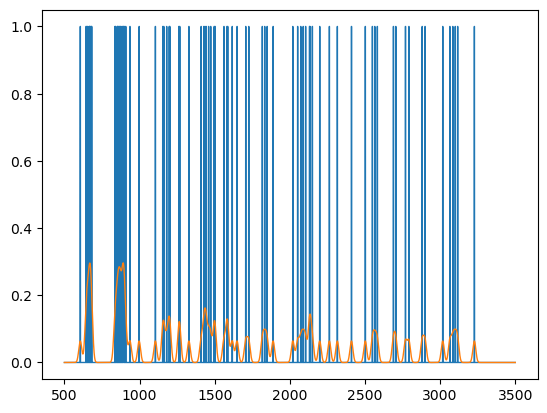

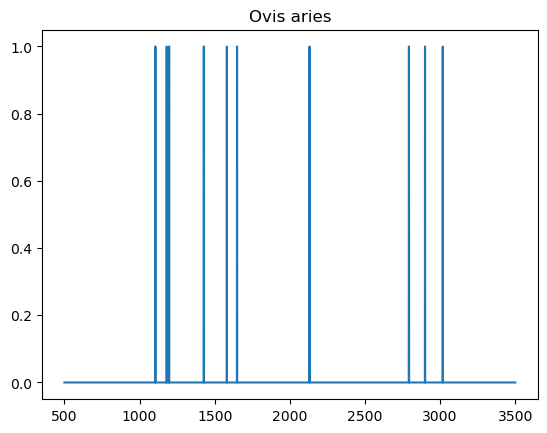

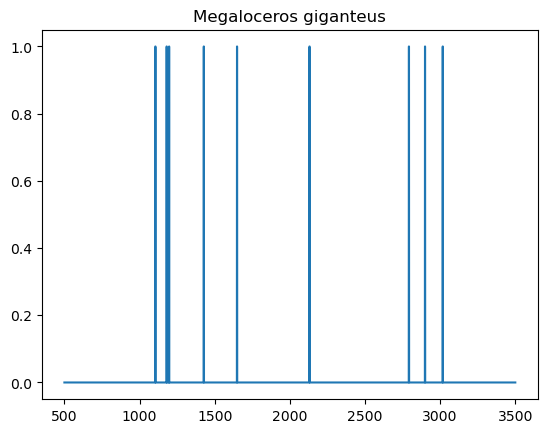

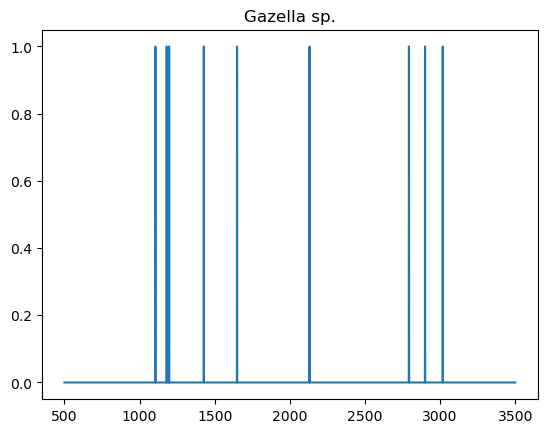

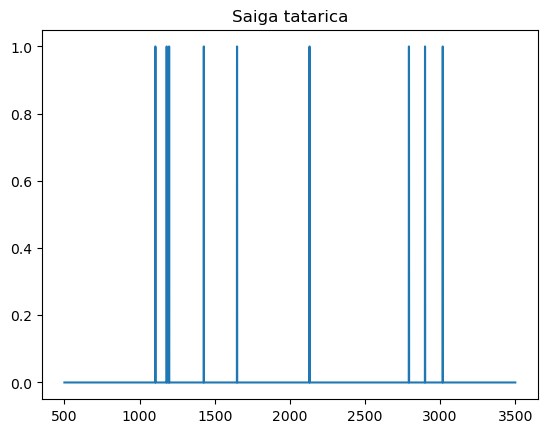

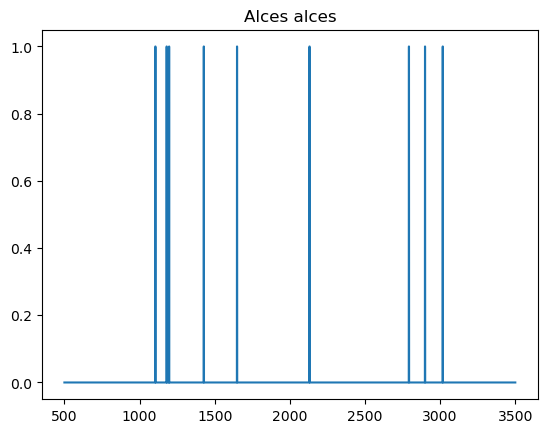

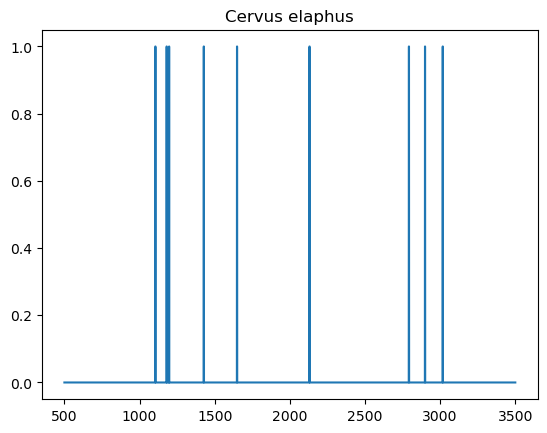

In [6]:
transform(df) # this carries out the previous function and shows you the peptide markers and species 

Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH8_1_A15.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH9_A21.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH1_A1.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH5_D9.csv


/var/folders/xl/cf_4bjhx1xd8k_919g05rkvm0000gn/T/ipykernel_61185/3652474002.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH3_A5.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH8_2_A17.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH10_A23.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH6_A11.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH7_A13.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH2_A3.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d/ASH8_3_A19.csv
Processing: /Users/emese/Docume

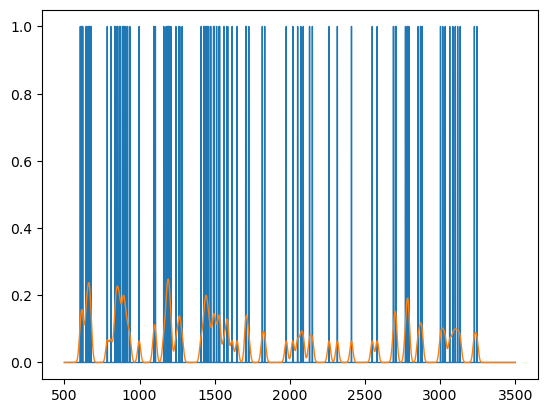

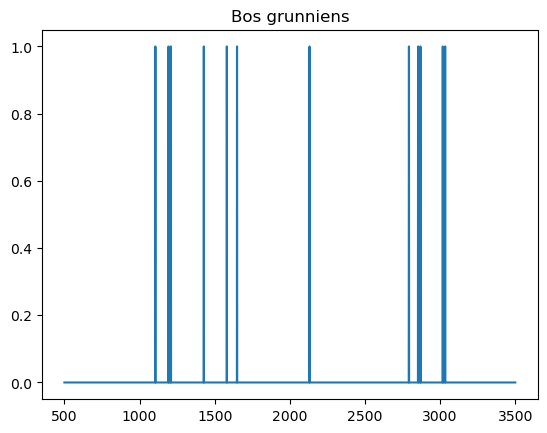

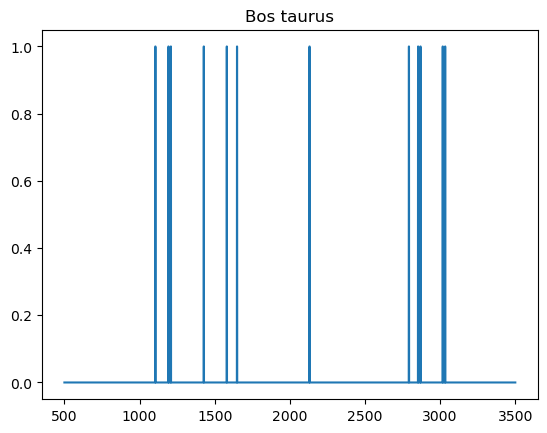

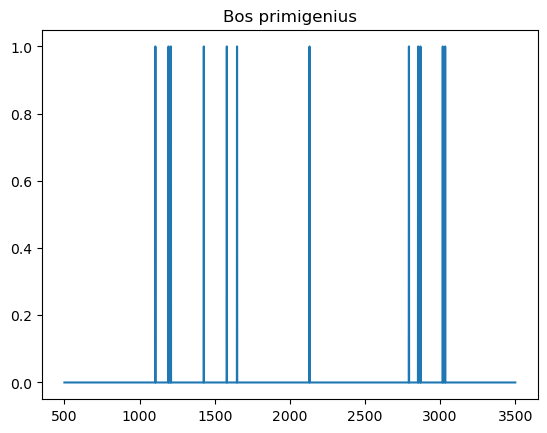

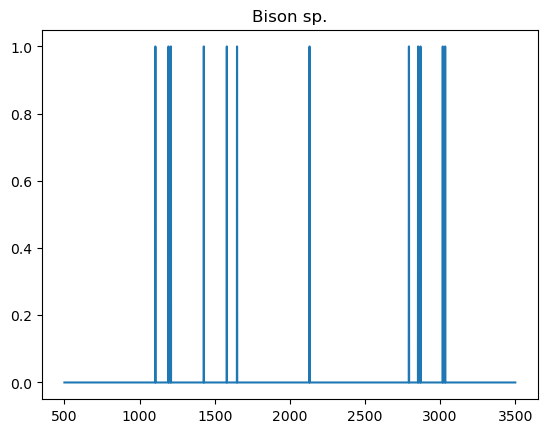

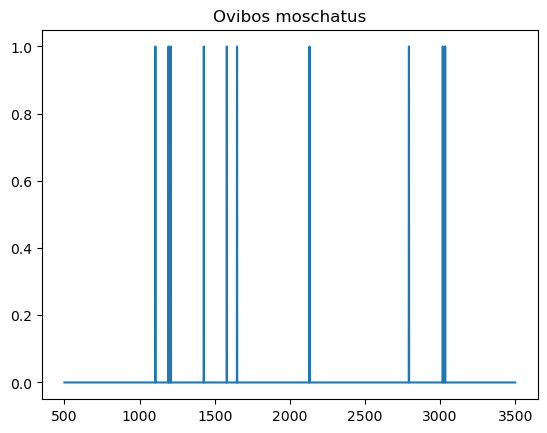

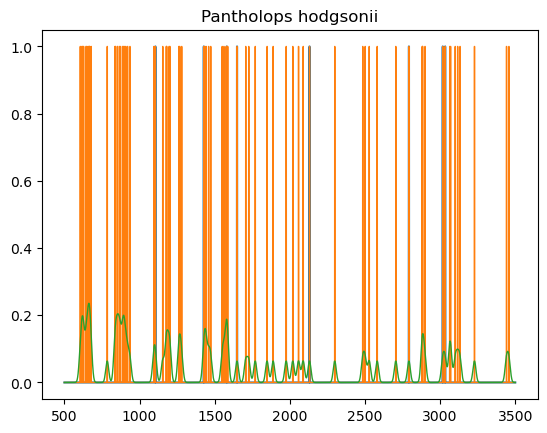

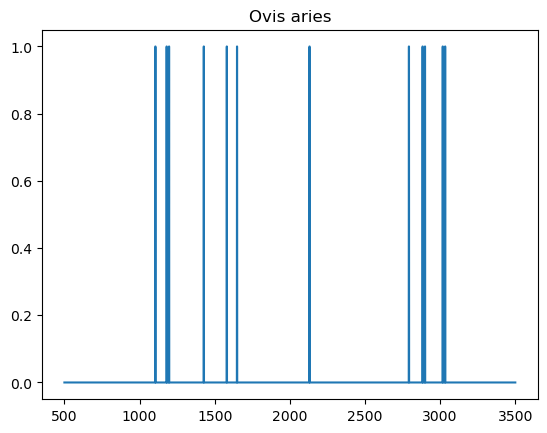

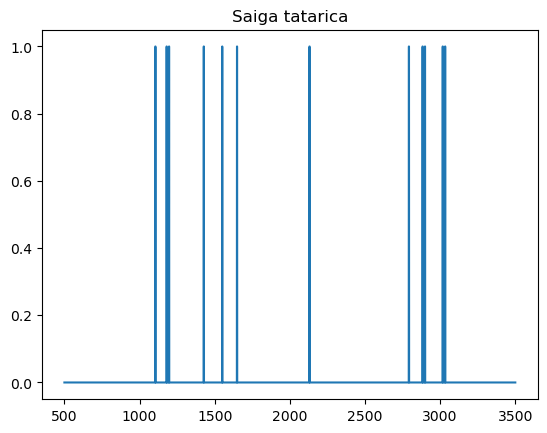

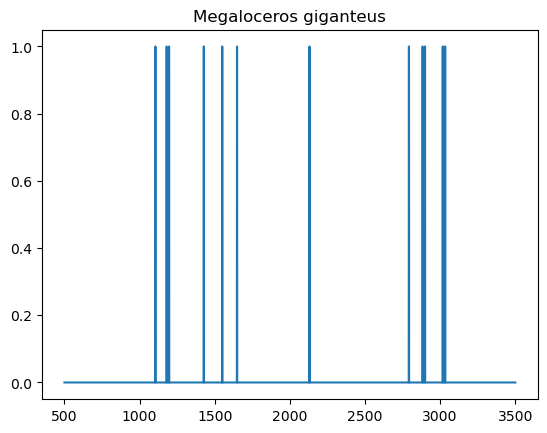

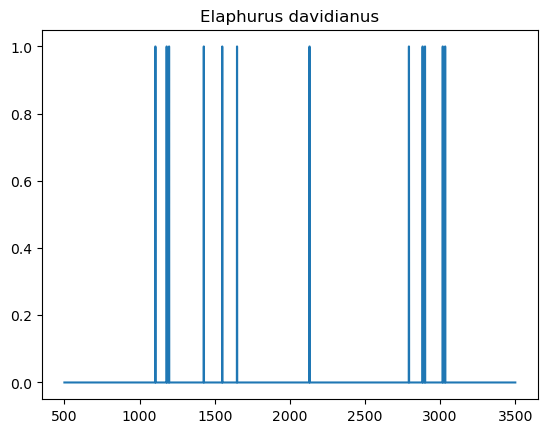

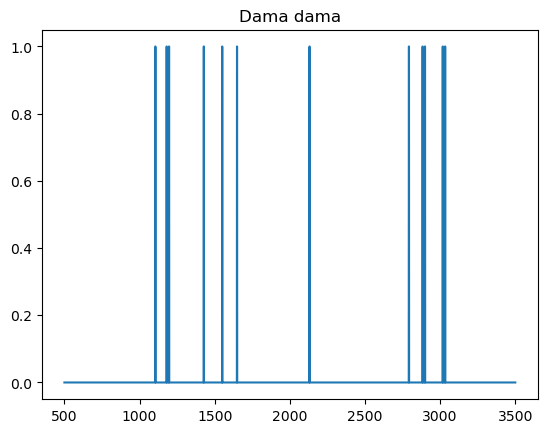

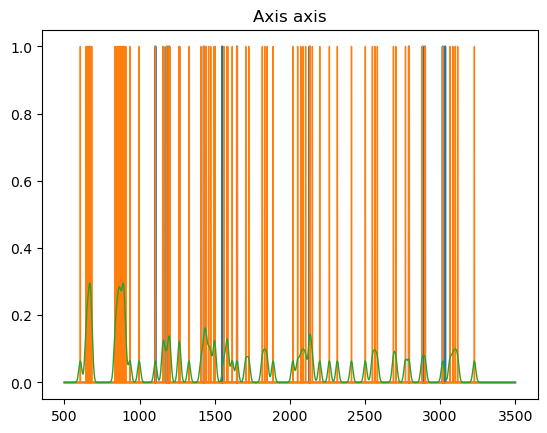

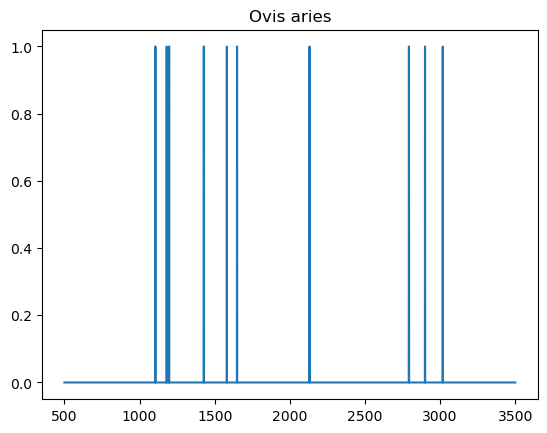

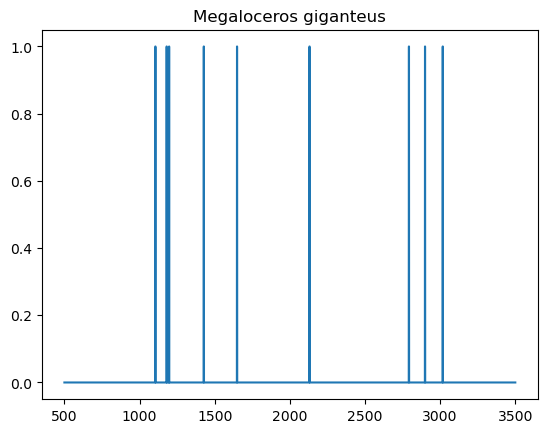

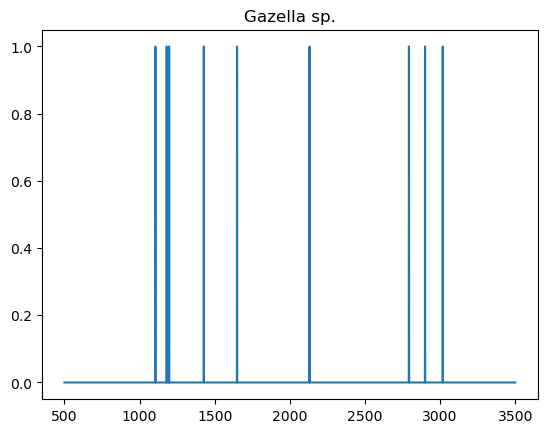

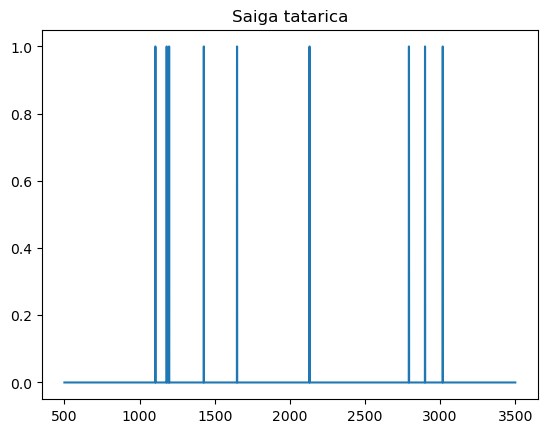

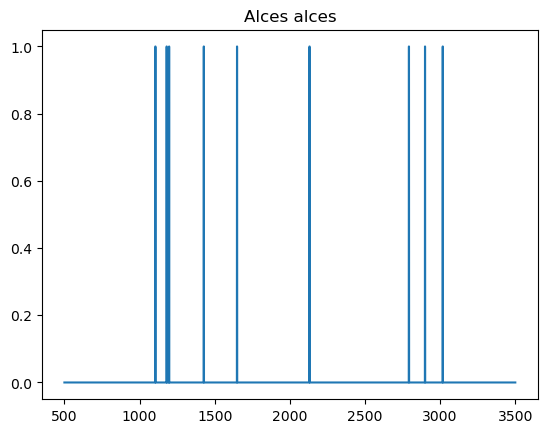

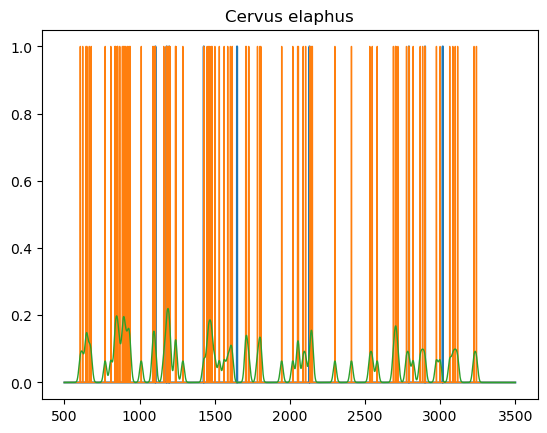

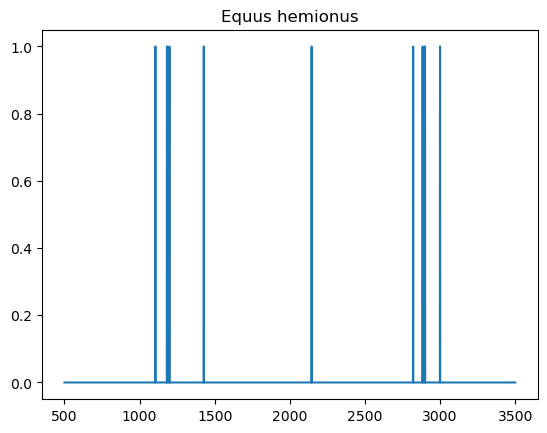

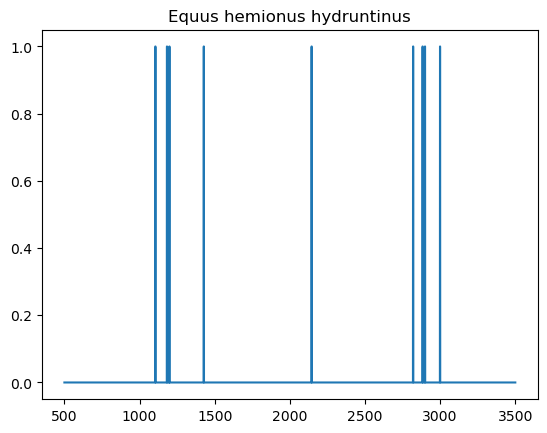

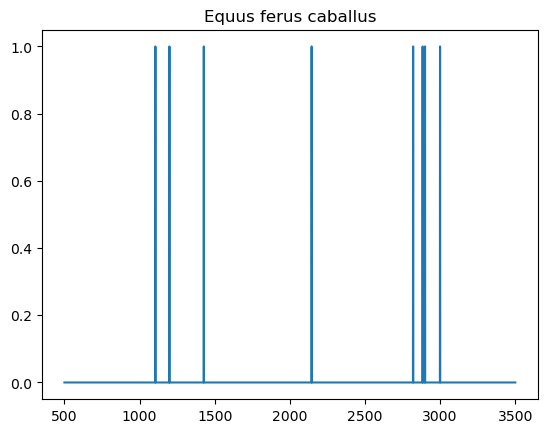

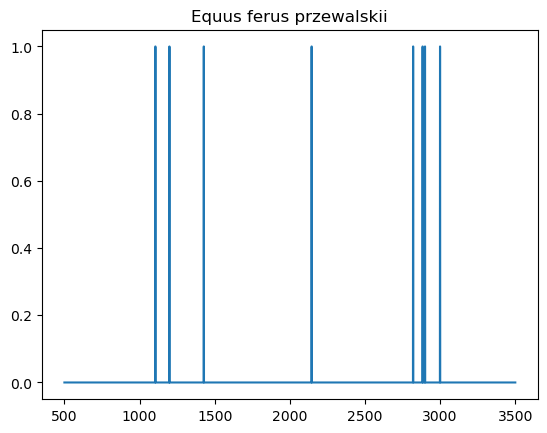

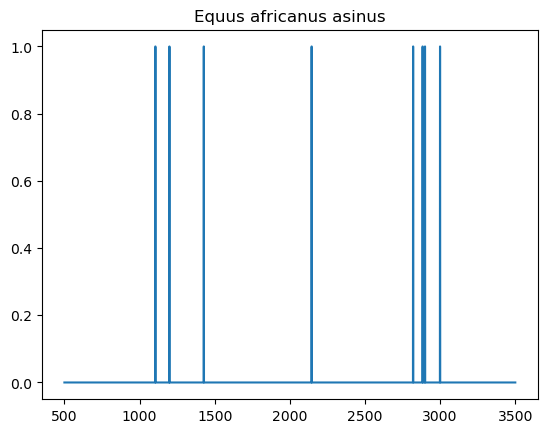

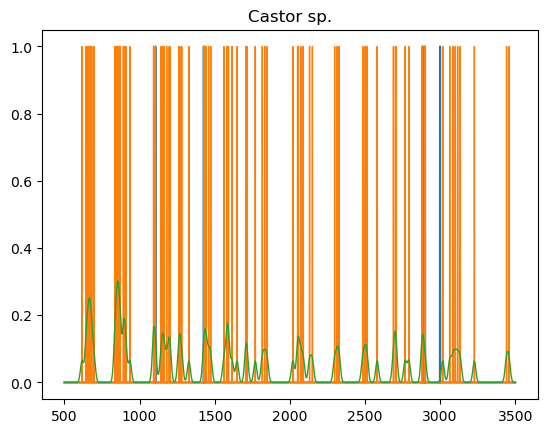

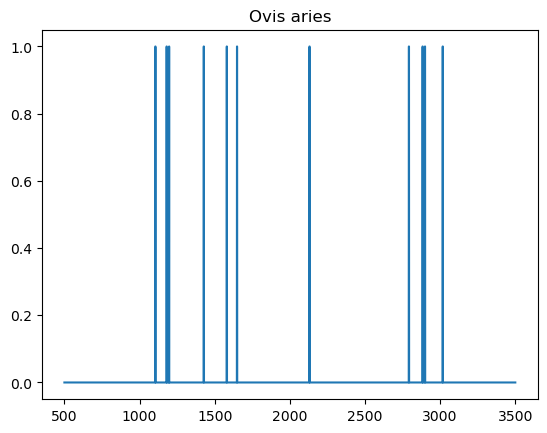

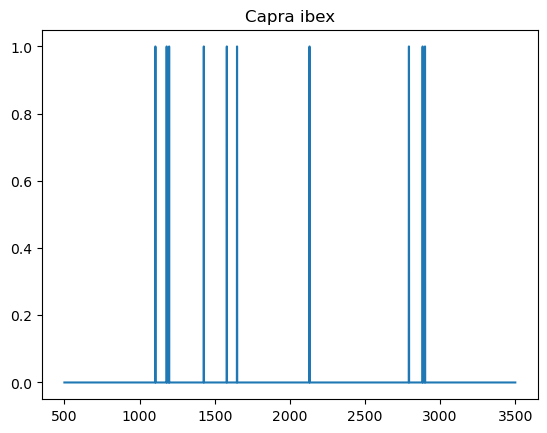

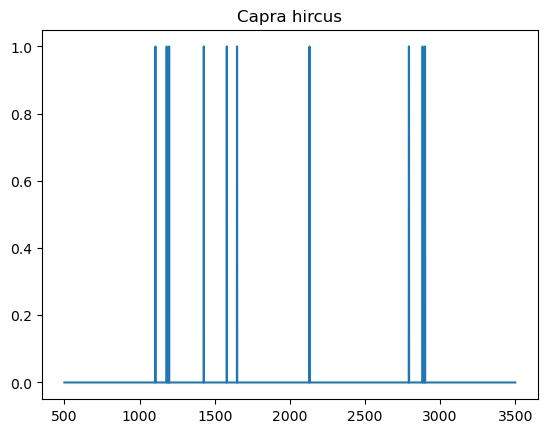

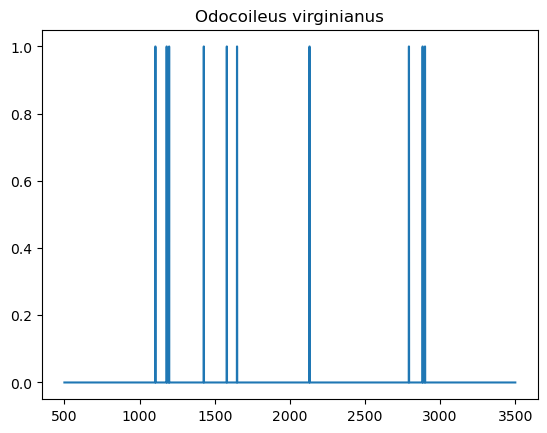

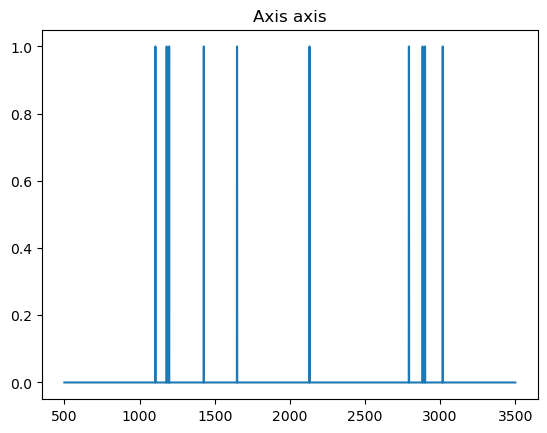

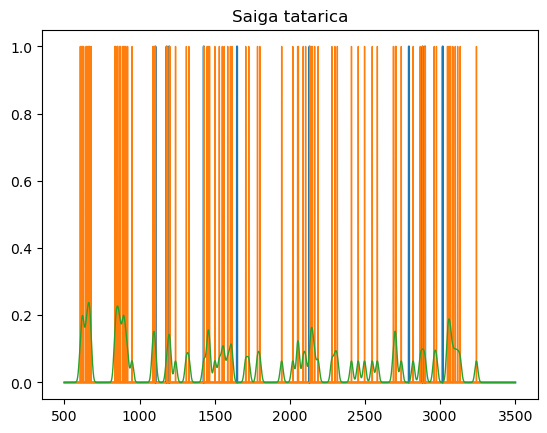

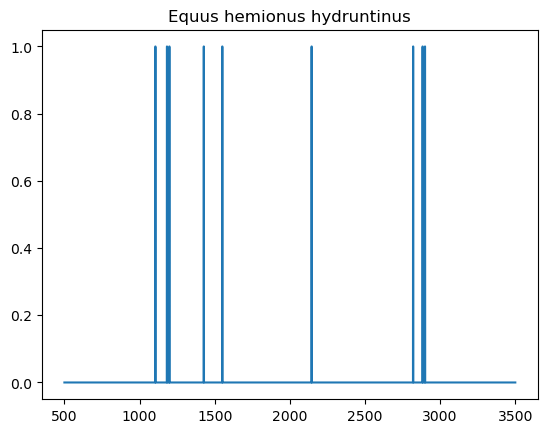

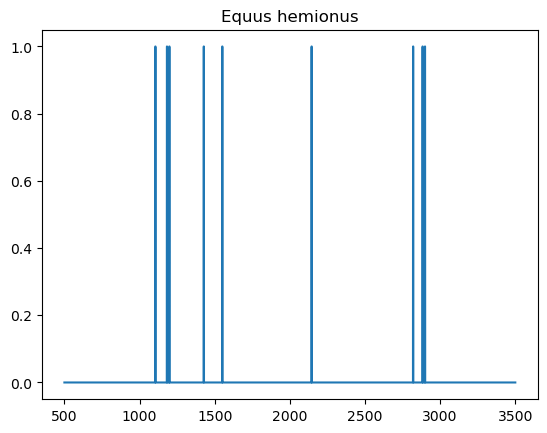

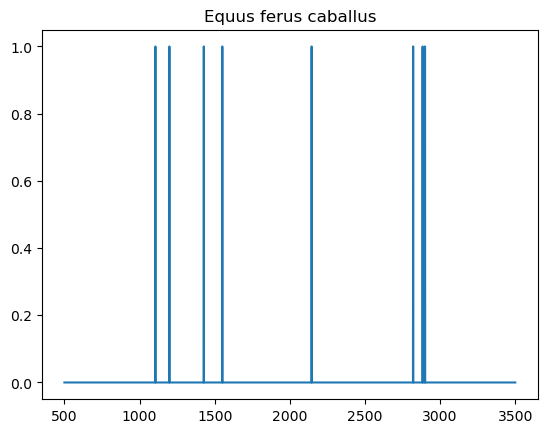

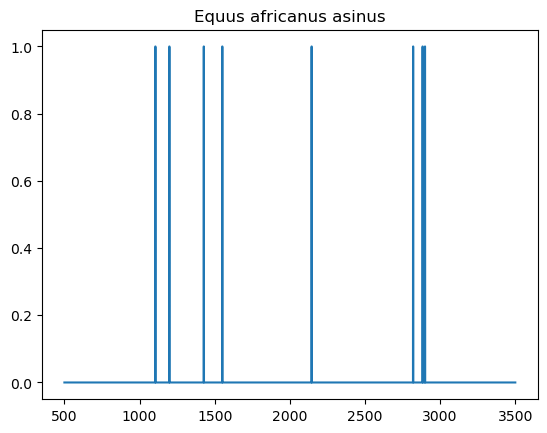

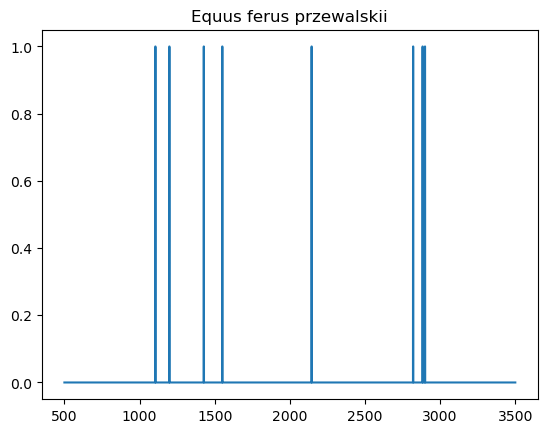

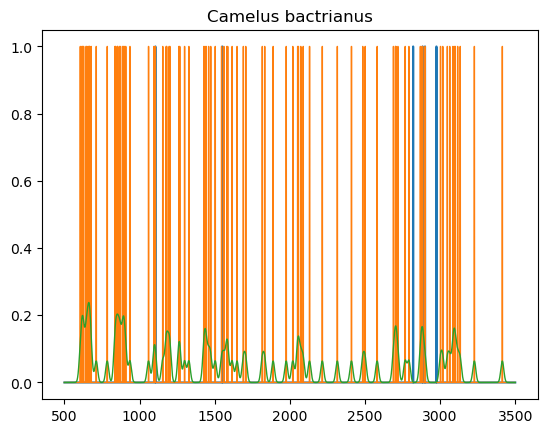

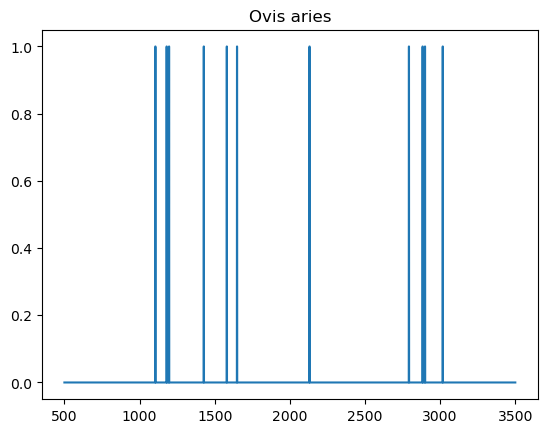

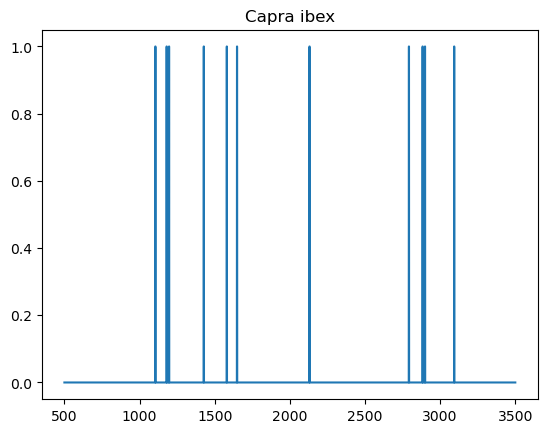

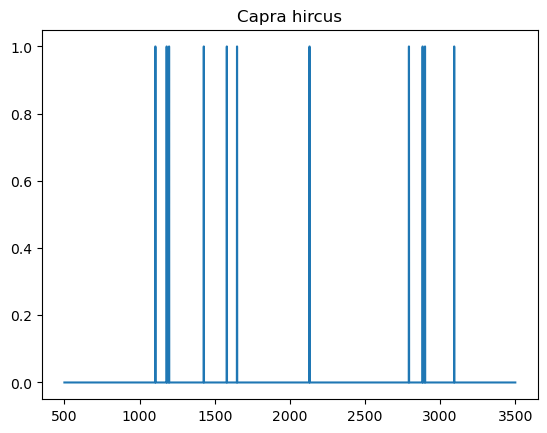

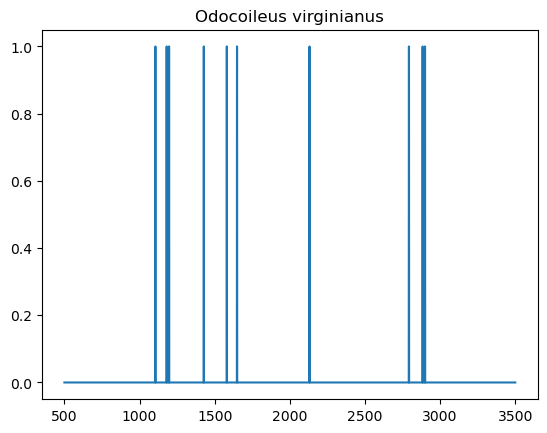

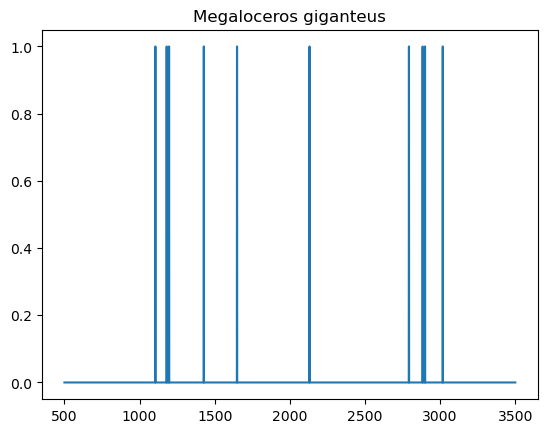

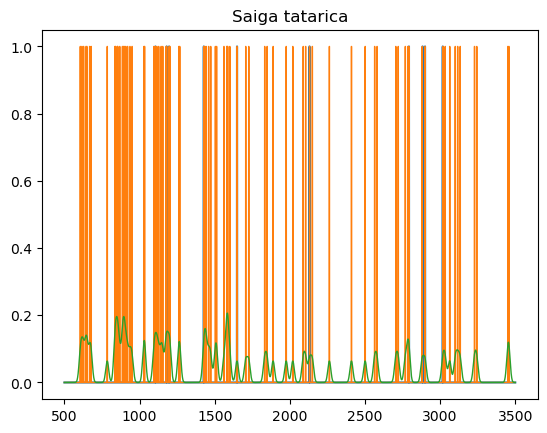

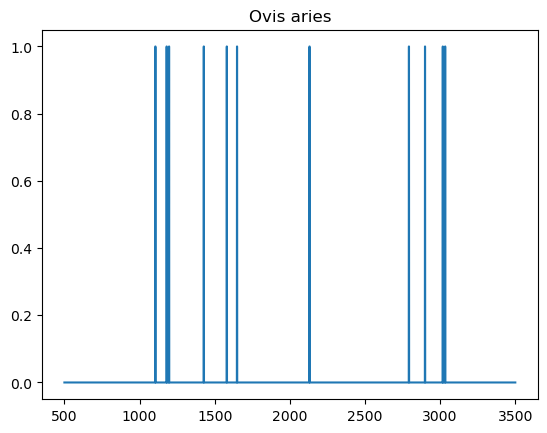

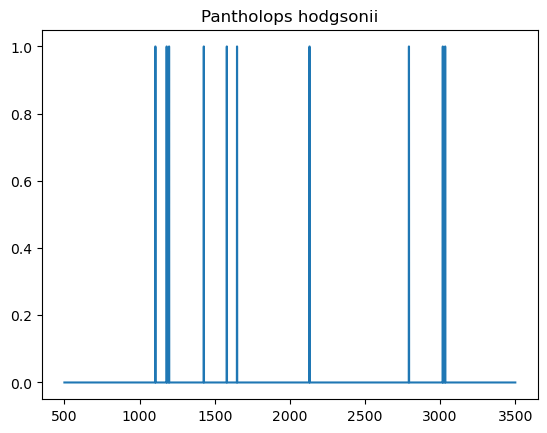

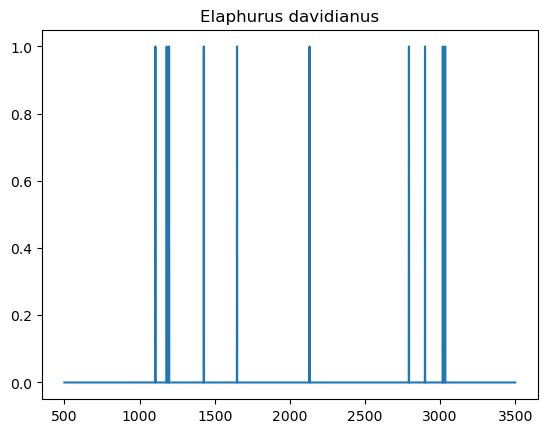

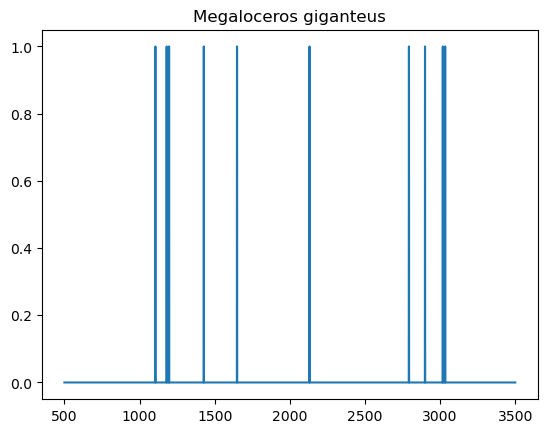

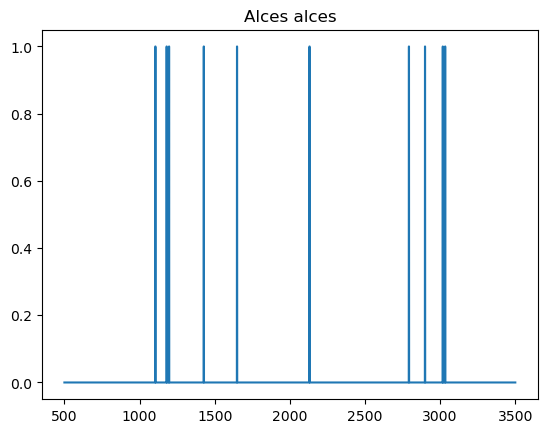

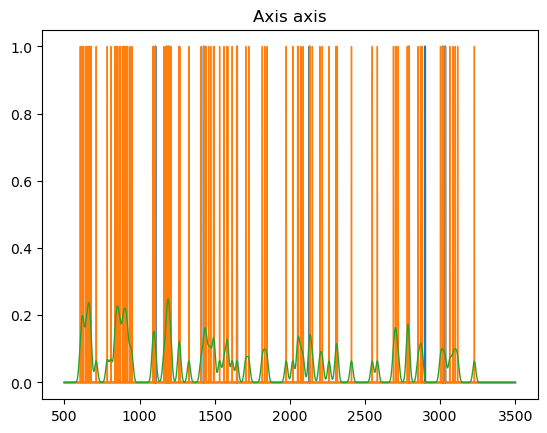

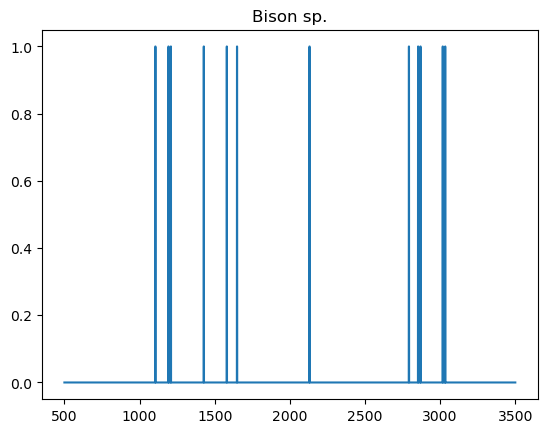

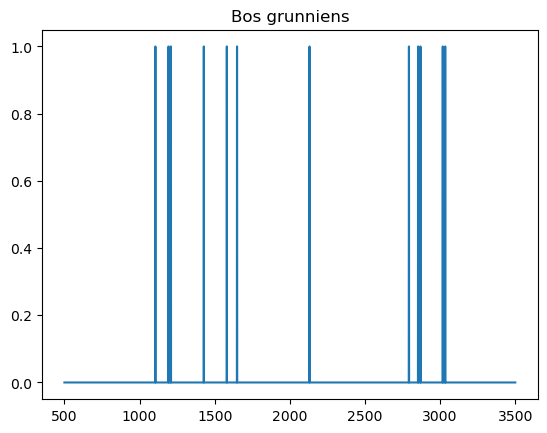

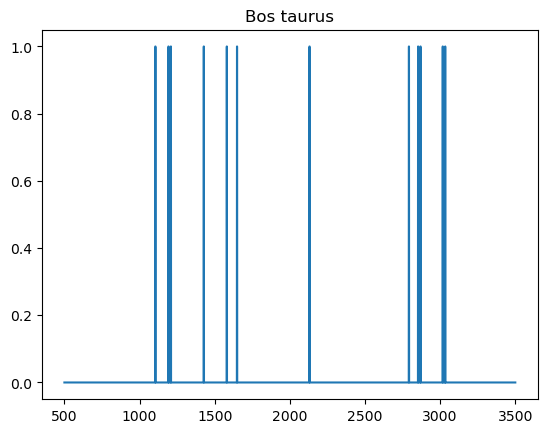

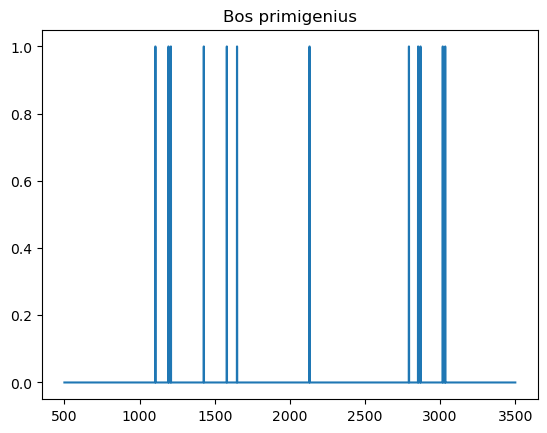

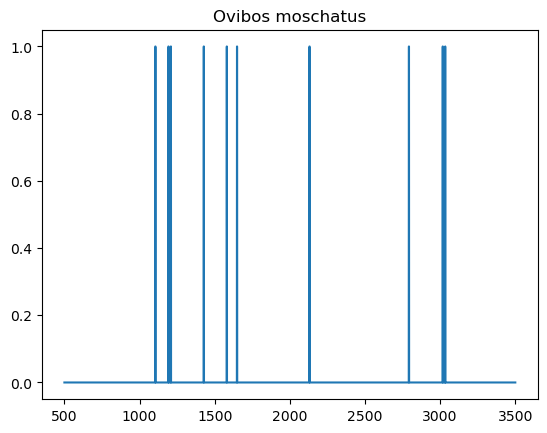

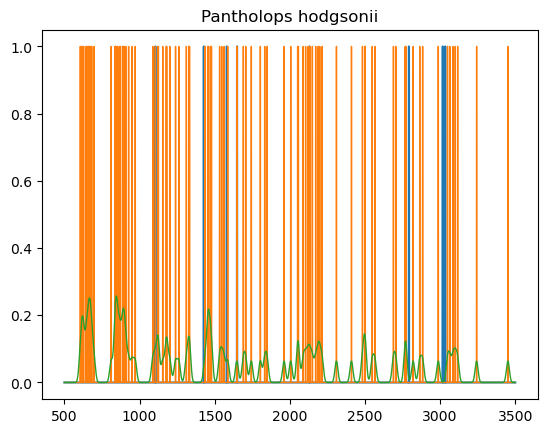

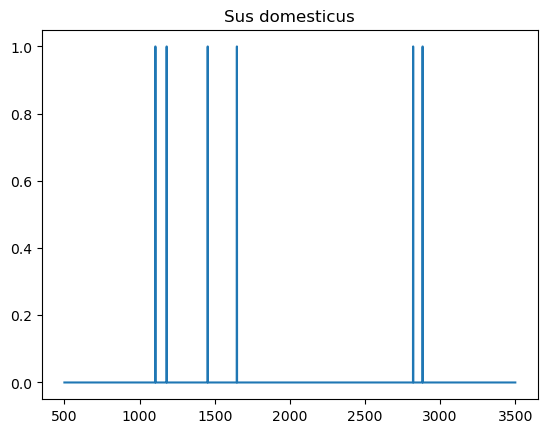

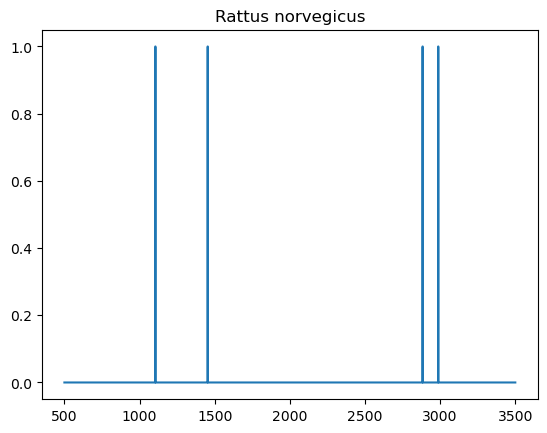

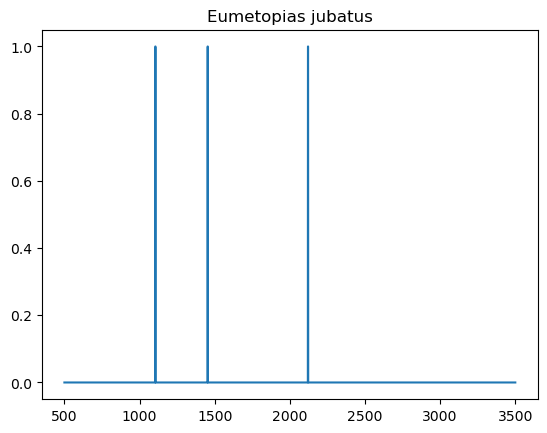

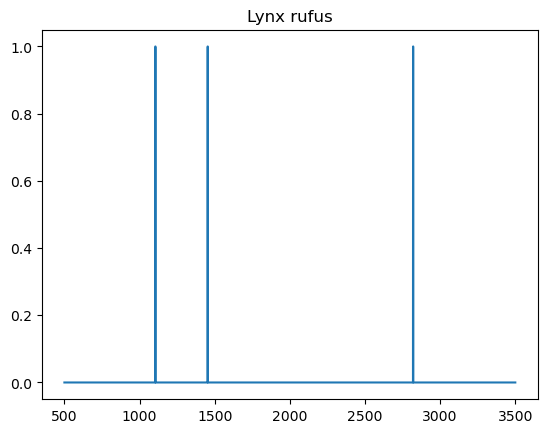

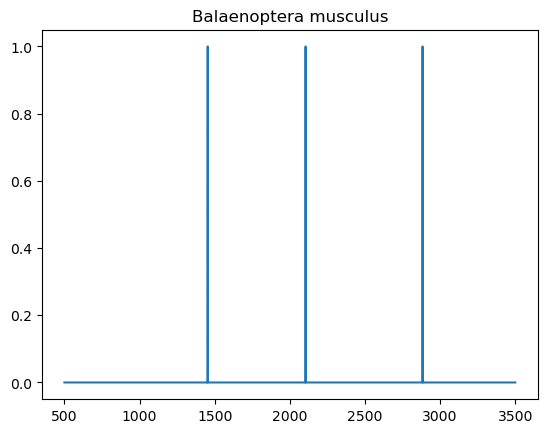

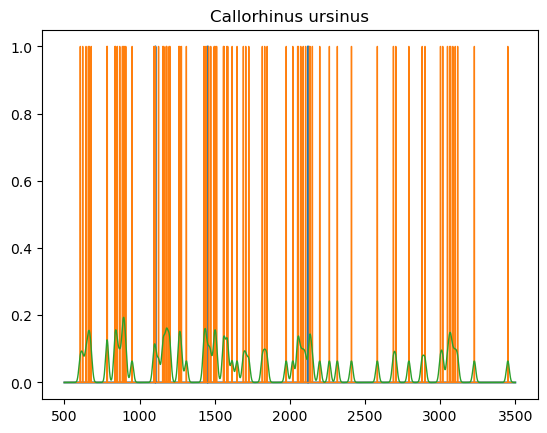

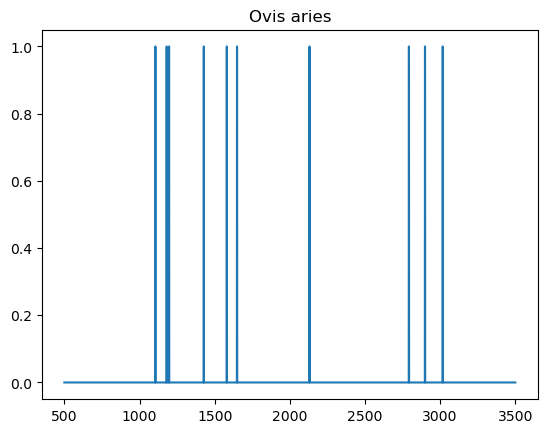

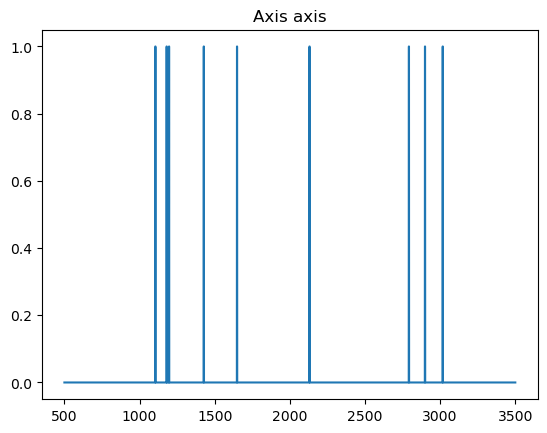

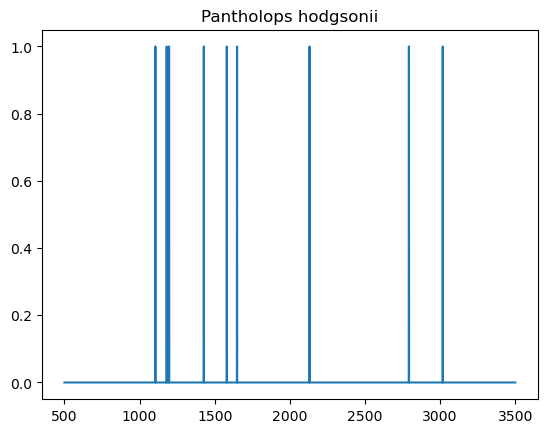

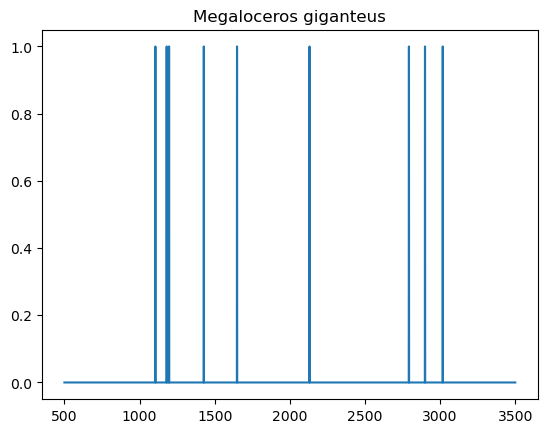

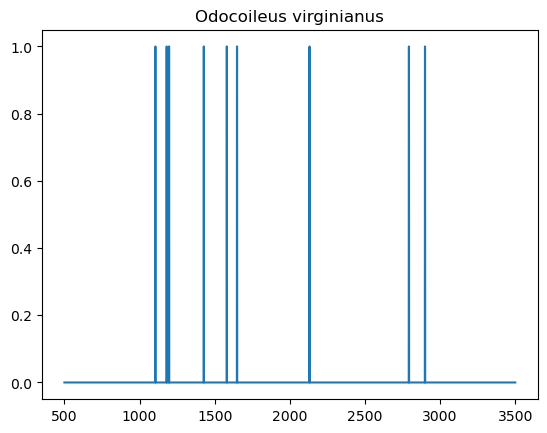

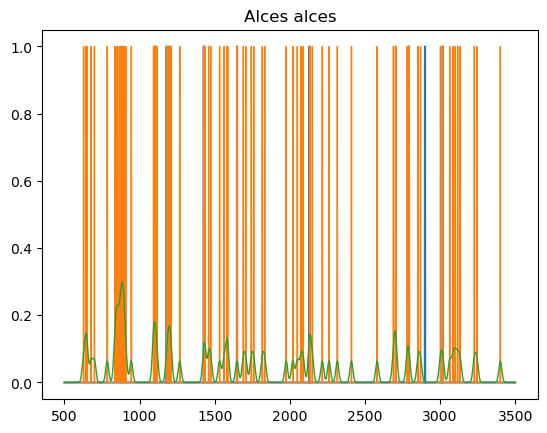

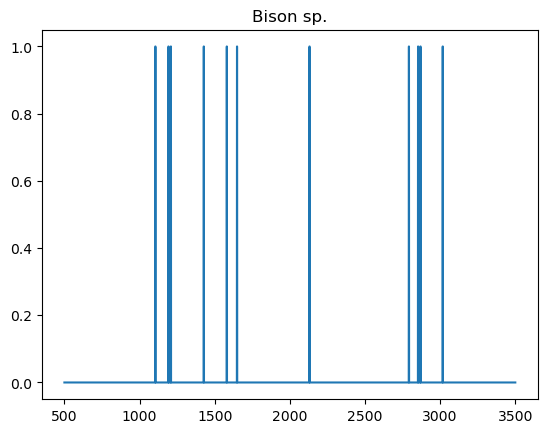

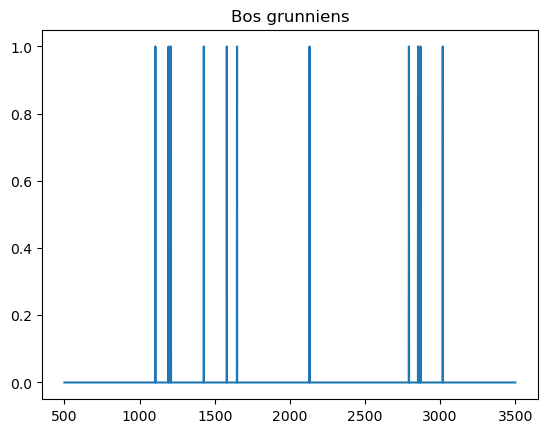

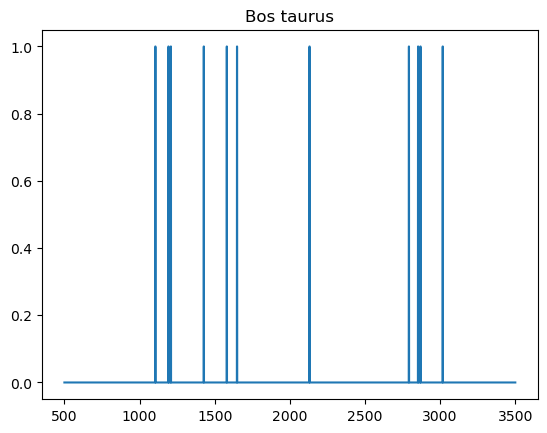

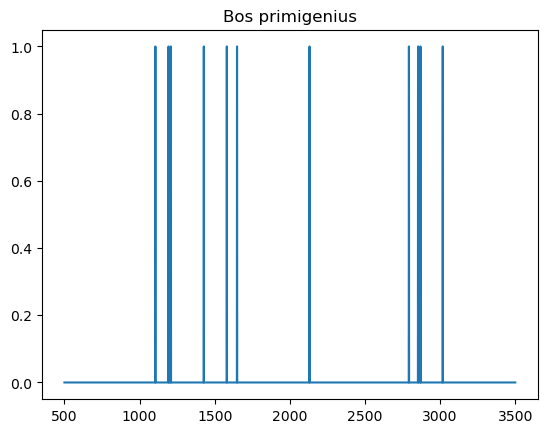

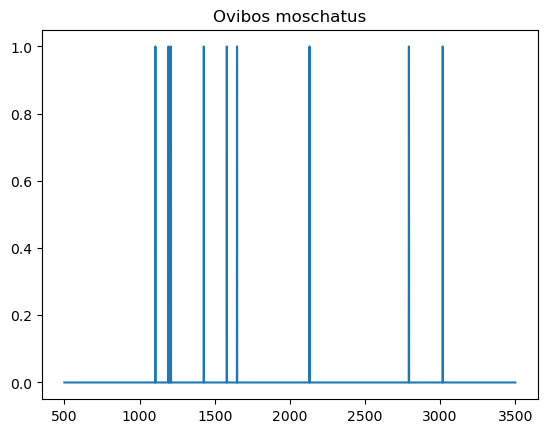

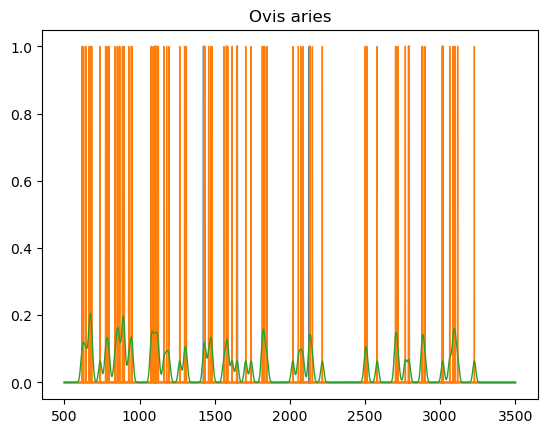

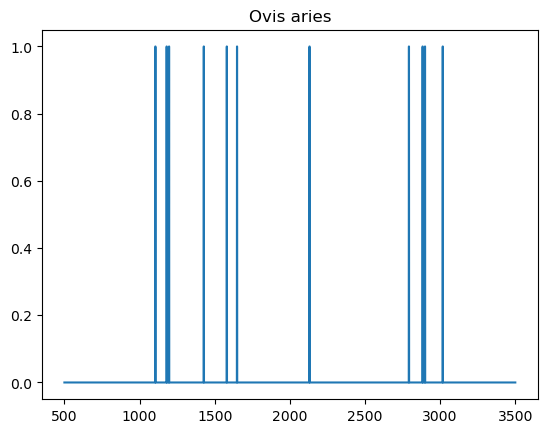

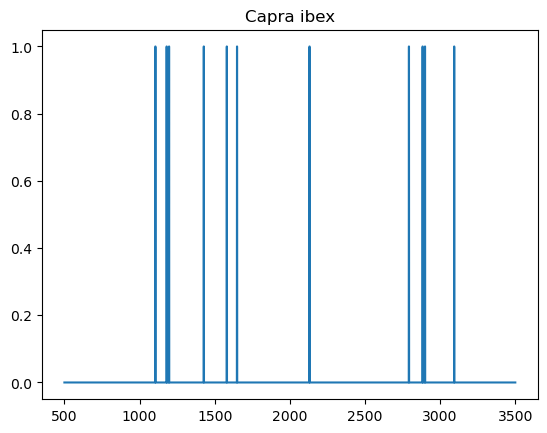

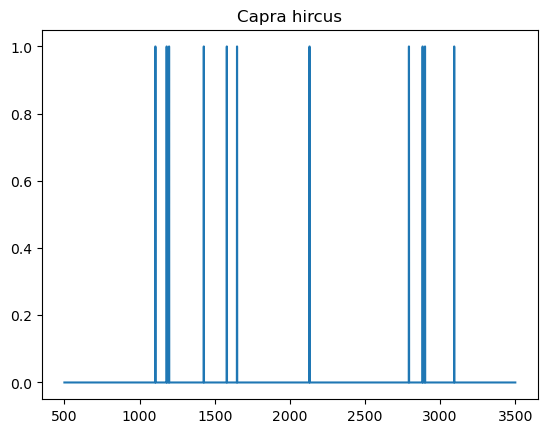

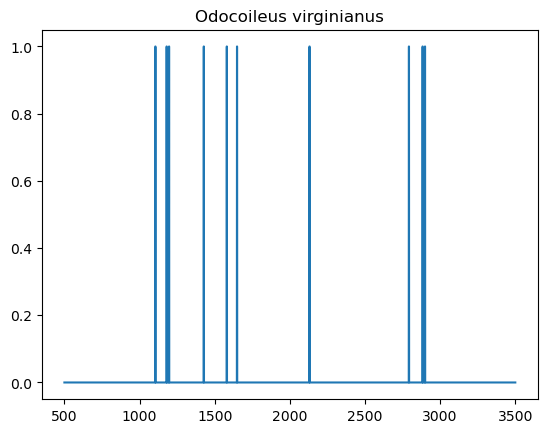

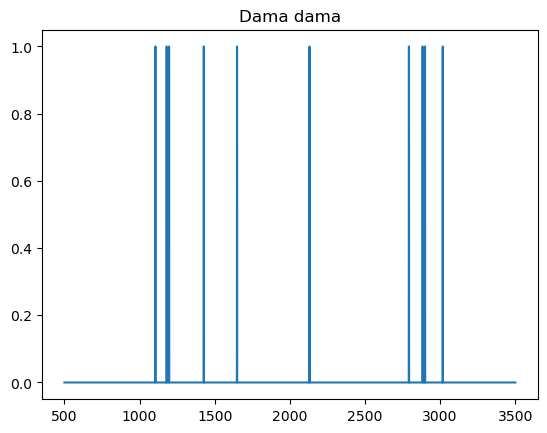

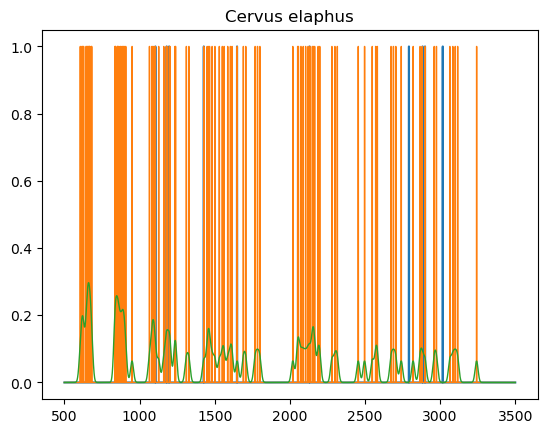

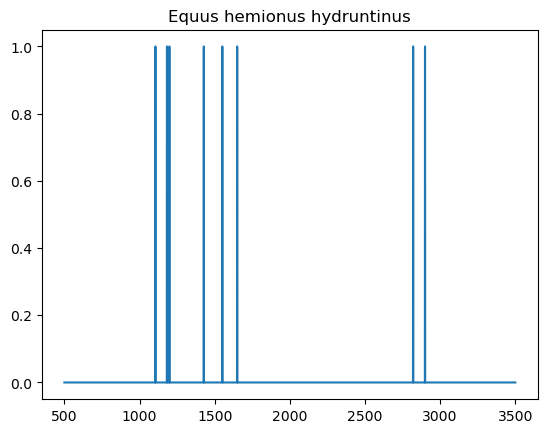

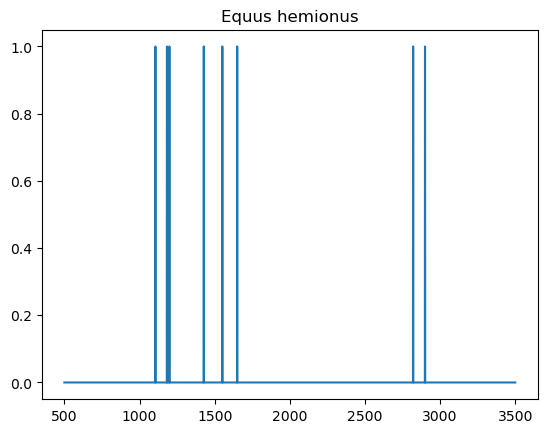

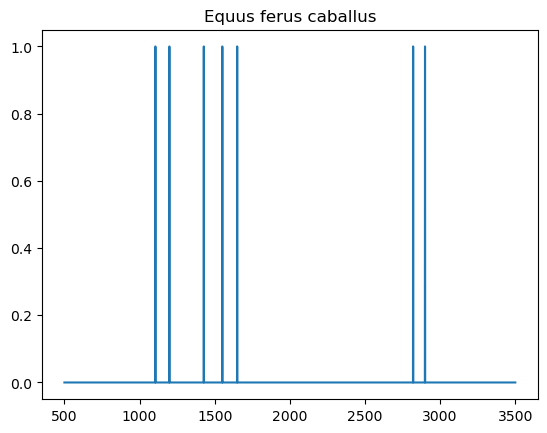

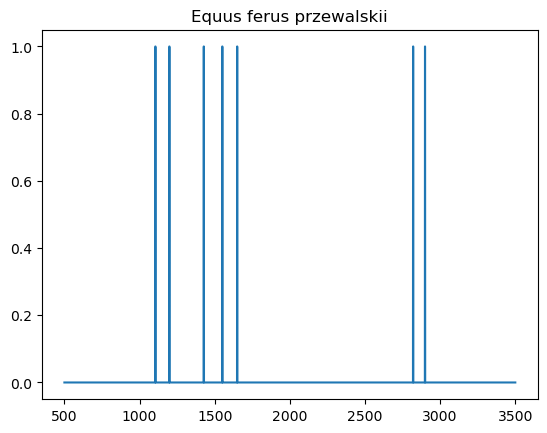

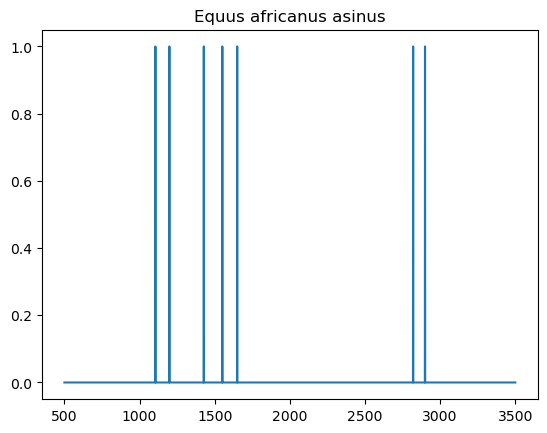

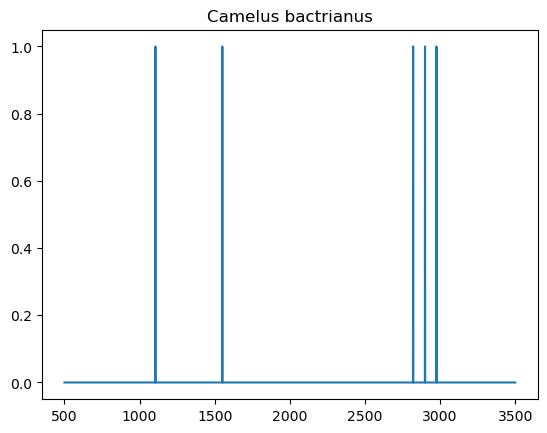

In [9]:
# Before running this: make a new folder with all the pre-processed .csv files of the unknown samples
# Batch process the whole folder
path = "/path_to_folder"
all_files = glob.glob(path + "/*.csv")

for path in all_files: #no need for the number
    print(f"Processing: {path}") # this will help debugging
    df = pd.read_csv(path)
    df_transformed = transform(df)

    path_no_csv = path.replace(".csv", "") #removes .csv at the end of path
    save_path = path_no_csv + "_all_d.csv" #adds the suffix you want -- e.g. peptide_species_results.csv
    df_transformed.to_csv(save_path)
# Once running this, it will make new csv files with the results in the folder you created

In [10]:
# Delete all csv-s in folder that does not contain 'all_d' (or the suffix you defined before, e.g. 'all_d' or 'peptide_species_results') in the file name (this will be useful for concatenating)

folder_path = "/path/to/folder"  # Replace with actual path to folder

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "_all_d" not in filename:
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print("Failed to delete file:", e)
# Once ran, check if the original files are deleted from the new folder and the new results are kept

In [ ]:
# Concatenate all the new results files
folder_path = '/Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_all_d'


# create an empty list to store dataframes
dfs = []

# loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # read the CSV file into a dataframe
        df = pd.read_csv(os.path.join(folder_path, filename))
        # add a new column with the file name as the value
        df["filename"] = filename
        # append the dataframe to the list
        dfs.append(df)

# concatenate all dataframes in the list into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)
#merged_df.to_csv("/Users/emese/Documents/Vienna/ZooMS_postdoc/Algorithm_paper/DCBatch3/DCBatch3_all_d_merged.csv")
# Make filename the index
merged_df = merged_df.set_index('filename')
# Drop Unnamed column
merged_df.drop('Unnamed: 0', axis=1, inplace=True)

# Drop the additional info in the name of the samples
merged_df.index = merged_df.index.str.split('_').str[0]

merged_df = merged_df.rename_axis("Sample")

merged_df.to_csv("/path_to_folder/Site_name_all_d_merged.csv")

In [18]:
# Read in an unknown sample's preprocessed peaks again from the same batch -- same as first step
df = pandas.read_csv("/path_to_csv/ASH1_A1.csv", sep=',')
fields = ['Order', 'Family', 'Common_name', 'Species', 'COL1_1_508_519', 'COL1_2_978_990', 'COL1_2_978_990_16', 'COL1a2_484___499', 'COL1a2_502___519', 'COL1a2_292___309', 'COL1a2_793___816', 'COL1a2_454___483', 'COL1a1_586___618', 'COL1a1_586___618_16', 'COL1a2_757___789', 'COL1a2_757___789_16']

reference = pd.read_csv('path_to_reference_db/ZooMS_reference_db_eurasia.csv', sep=";",encoding='UTF-8', header=None, names=fields)
peak_markers = list(reference.columns)[4:]

ref_peaks = reference[peak_markers].drop(0, axis=0).astype(float)

In [19]:
# Run again to get correlation/similarity scores

def transform_similarity(df):
    df_copy = df.copy() # making a copy so I dont have to reload the dataframe everytime
    #make changes to df_copy  
    x = np.arange(500, 3500, 0.1)
    pi = np.array(ref_peaks.iloc[0].to_numpy())
    pi = pi[~np.isnan(pi)]      
    resampled = np.zeros_like(x)
    for p in df_copy['mass']:
        resampled[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
        
    resampled_smooth = gaussian_filter1d(resampled, 100)
    plt.plot(x, resampled, label='sample', linewidth=1)
    plt.plot(x, resampled_smooth, label='sample', linewidth=1)
    
    n_spec = ref_peaks.shape[0]
    corrs = np.zeros(n_spec)
    for i in range(n_spec):
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        for p in pi:
            y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
            corrs[i] = np.corrcoef(y, resampled)[0,1]
        ranks = pd.DataFrame({'Order':reference['Order'][1:],'Family':reference['Family'][1:], 'Species':reference['Species'][1:], 'similarity':corrs})
    
    idx = ranks.sort_values(by='similarity', ascending=False).index[:6] - 1
    # index [6] because the first 6 matches of soecies -- how many first similars i want to look at
    
    all_d = pd.DataFrame(columns=ref_peaks.columns)
    for i in idx:
        y = np.zeros_like(x)
        pi = np.array(ref_peaks.iloc[i].to_numpy())
        pi = pi[~np.isnan(pi)]
        for p in pi:
            y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
        
        plt.figure()
        plt.plot(x, y * resampled)
        plt.title(reference['Species'][i+1]);

        v, ix, iy = np.intersect1d((np.round(pi, decimals=1)*10).astype(int), (x[y*resampled==1]*10).astype(int), return_indices=True)
        d = pd.DataFrame({k:p for k, p in zip(ref_peaks.columns[ix],v/10)}, index=[reference['Species'][i+1]])
        all_d = pd.concat([all_d, d], axis=0)
    
    ranks_df = ranks.sort_values(by='similarity', ascending=False)
    pd.concat([all_d, ranks_df], axis=1)
    results_concated = pd.concat([all_d, ranks_df], axis=1)
    

    
    return ranks_df

,Order,Family,Species,similarity
37,Artiodactyla,Bovidae,Ovis aries,0.236744
67,Artiodactyla,Cervidae,Megaloceros giganteus,0.226429
26,Artiodactyla,Bovidae,Gazella sp.,0.226429
45,Artiodactyla,Bovidae,Saiga tatarica,0.226429
59,Artiodactyla,Cervidae,Alces alces,0.226429
...,...,...,...,...
78,Artiodactyla,Delphinidae,Pseudorca crassidens,-0.013859
73,Artiodactyla,Delphinidae,Globicephala sp.,-0.013859
120,Carnivora,Phocidae,Erignathus barbatus,-0.014703
75,Artiodactyla,Delphinidae,Lagenorhynchus albirostris,-0.014703


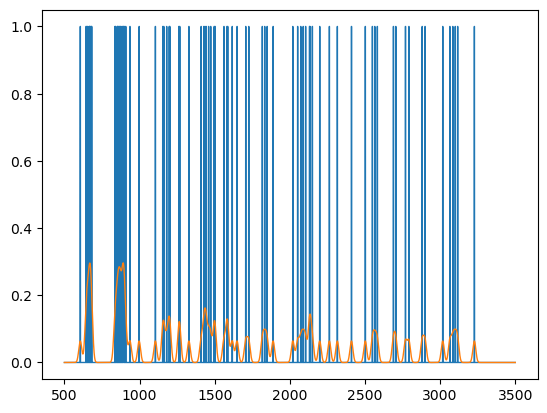

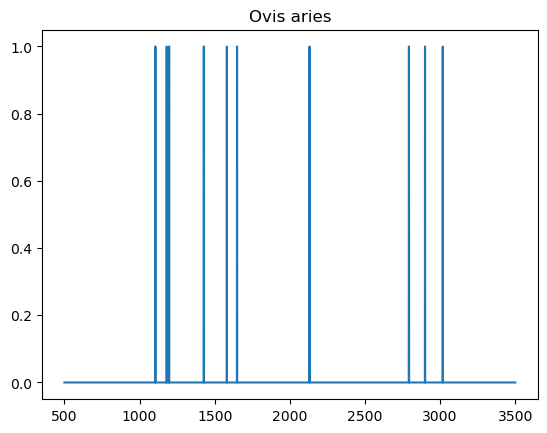

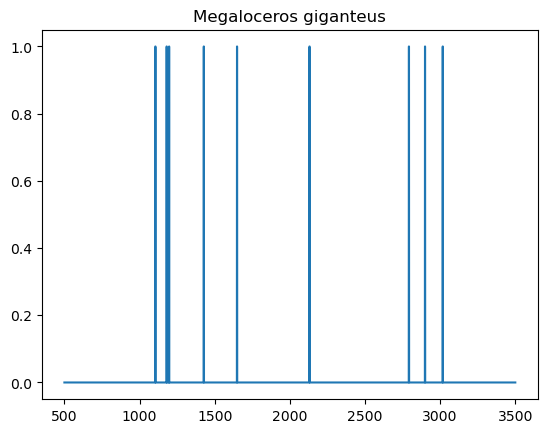

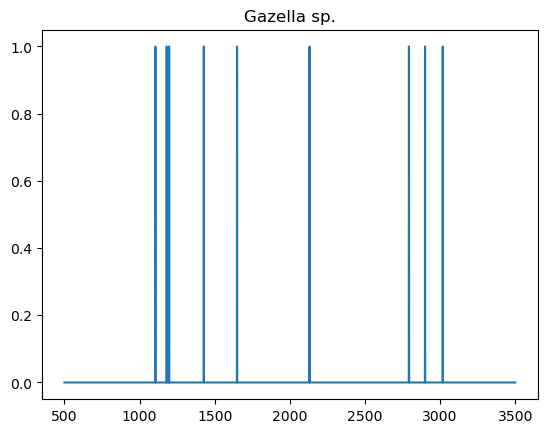

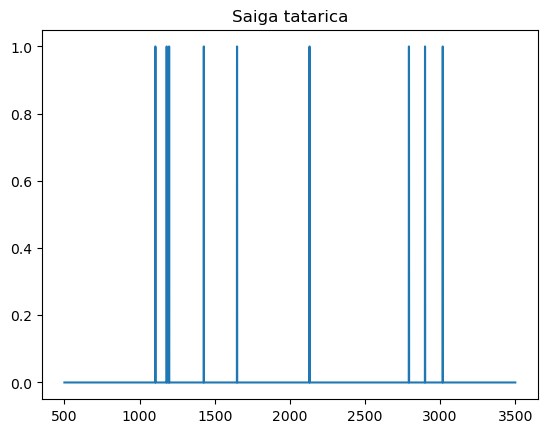

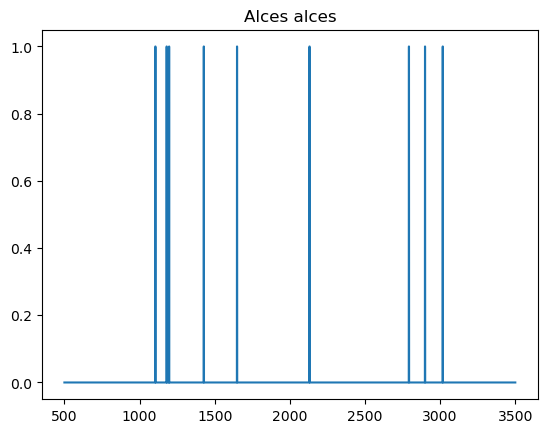

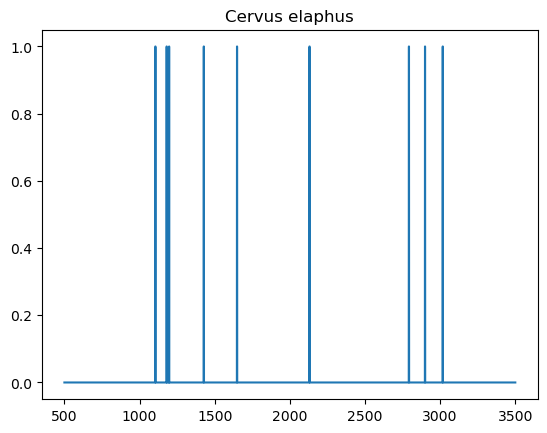

In [20]:
# Run similarity function for similarity scores
transform_similarity(df)

Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH8_1_A15.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH9_A21.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH1_A1.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH5_D9.csv


/var/folders/xl/cf_4bjhx1xd8k_919g05rkvm0000gn/T/ipykernel_61185/3652474002.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH3_A5.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH8_2_A17.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH10_A23.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH6_A11.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH7_A13.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH2_A3.csv
Processing: /Users/emese/Documents/Vienna/ZooMS_postdoc/MALDI_RAW_DATA/MOR-ASH_converted/MOR-ASH_preprocessed_csvs/ASH_similarity/ASH8_3_A19.

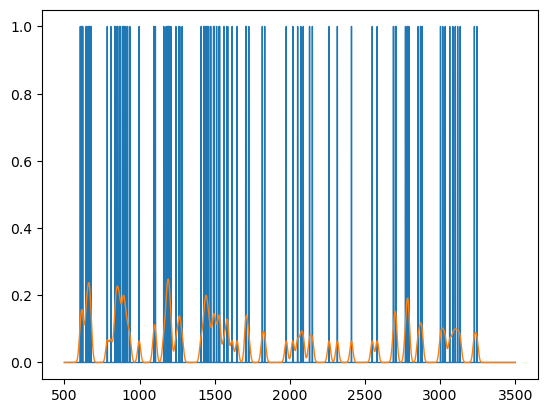

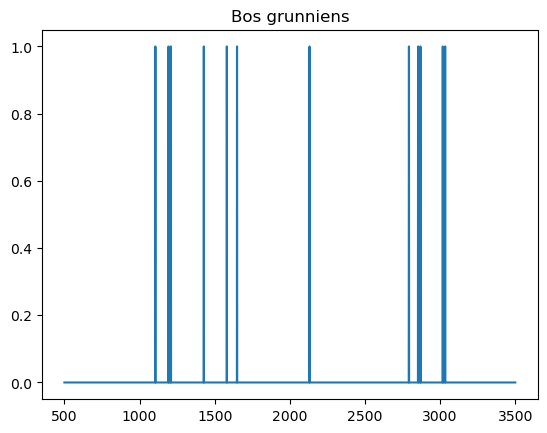

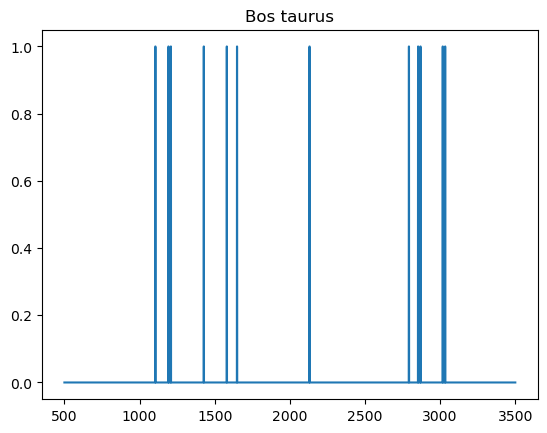

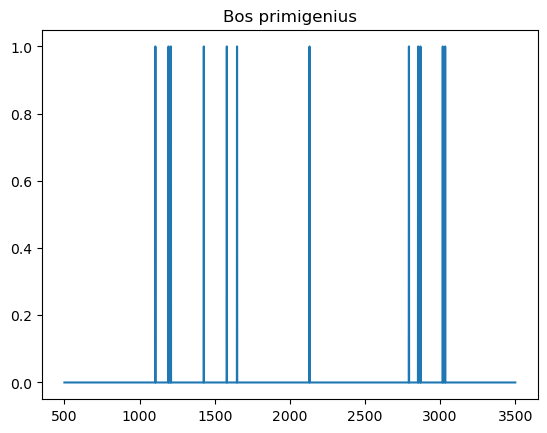

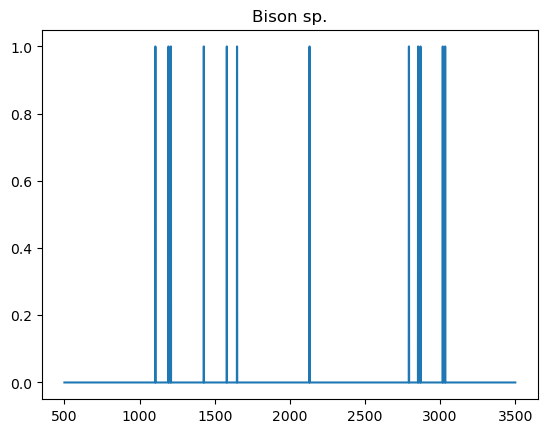

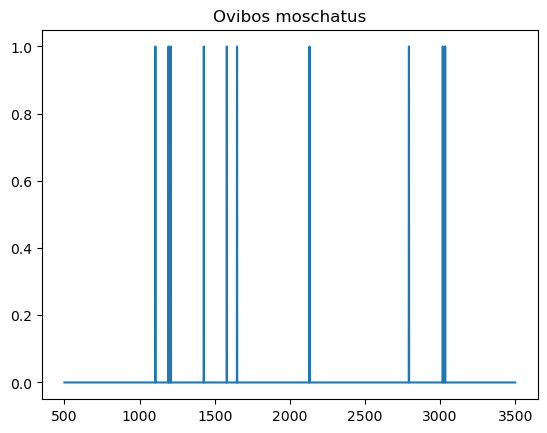

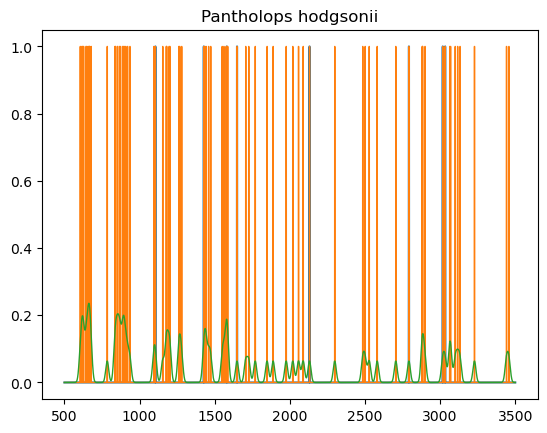

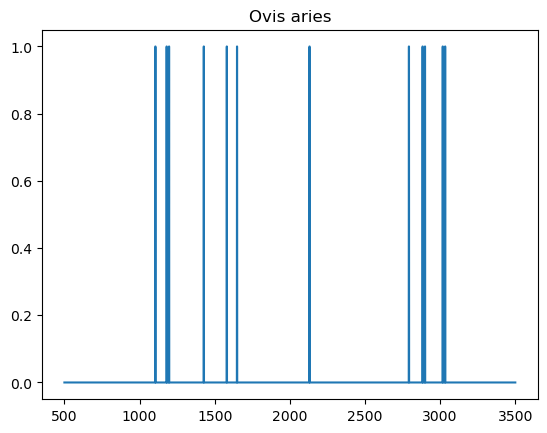

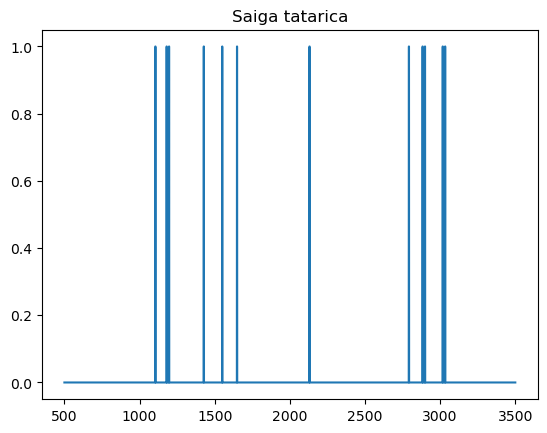

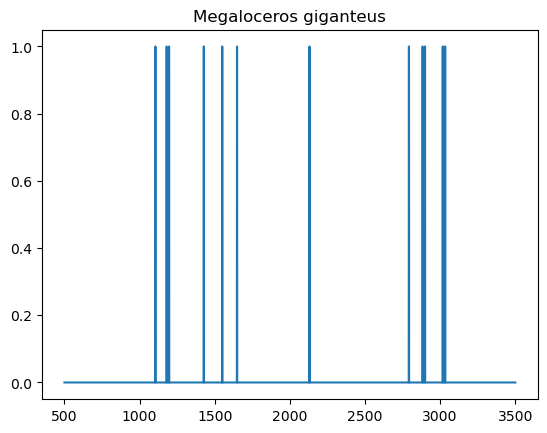

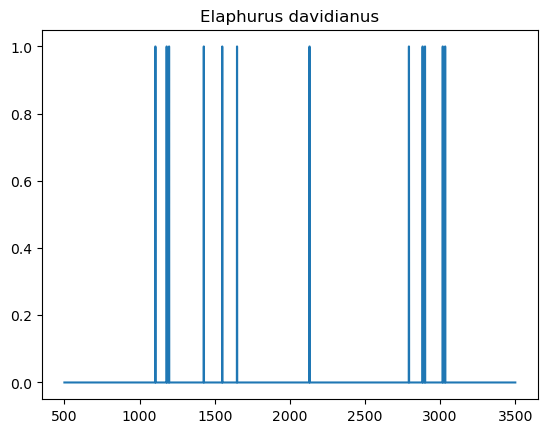

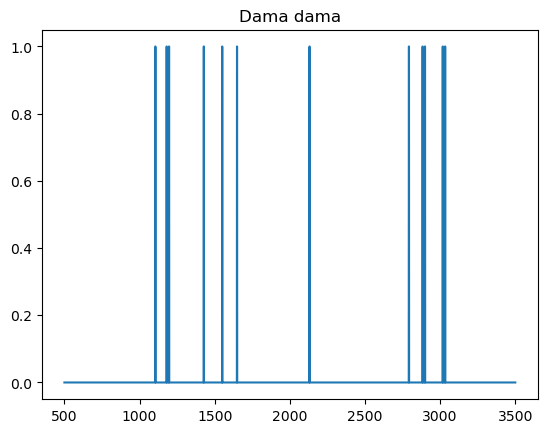

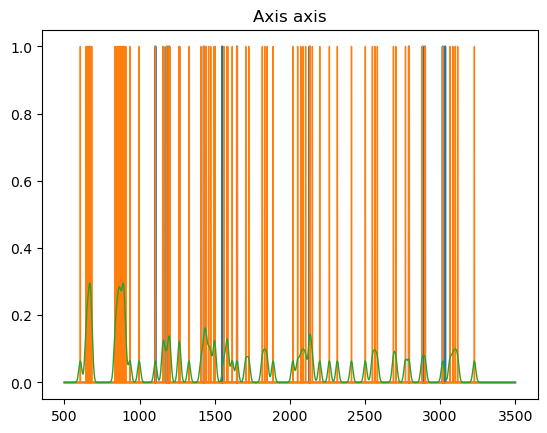

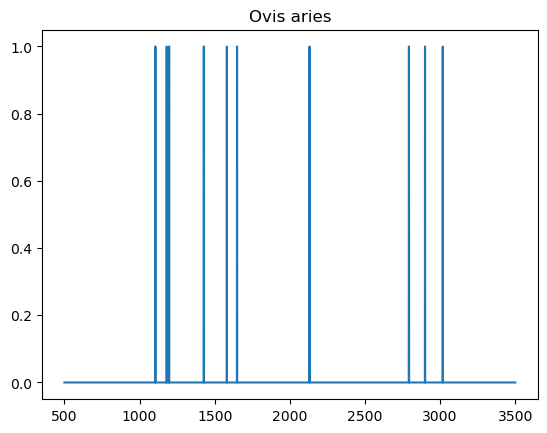

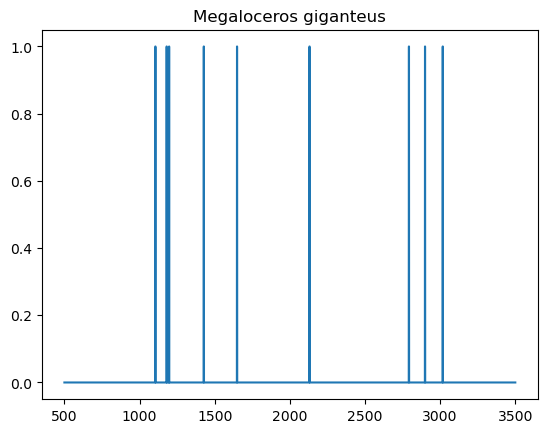

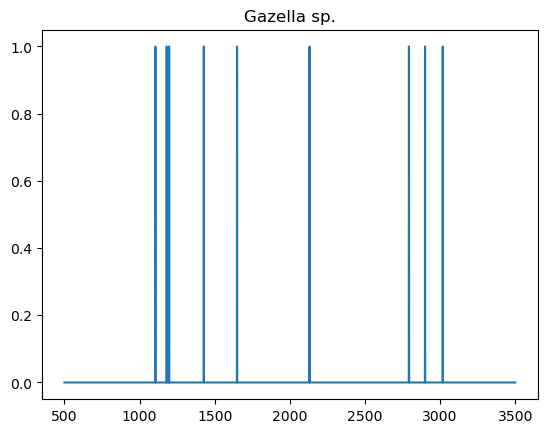

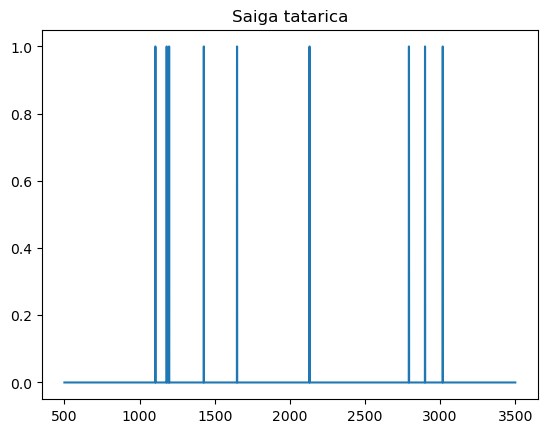

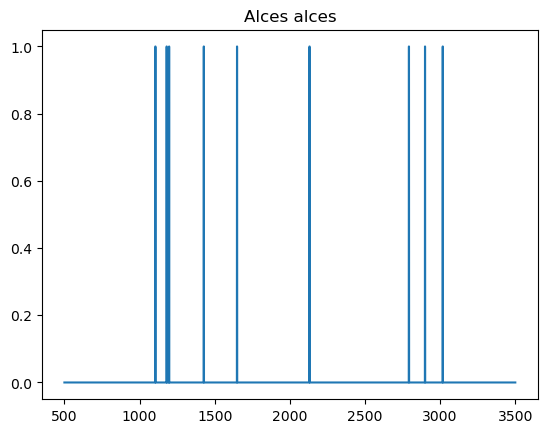

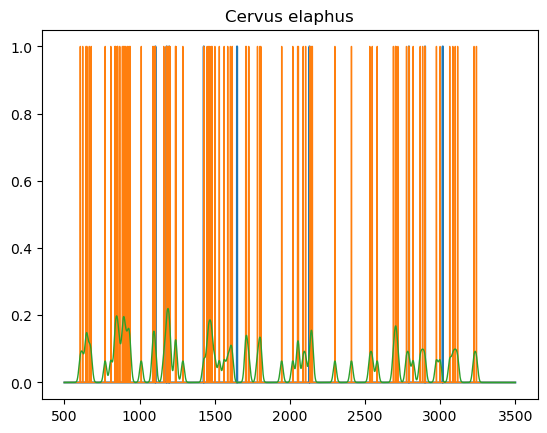

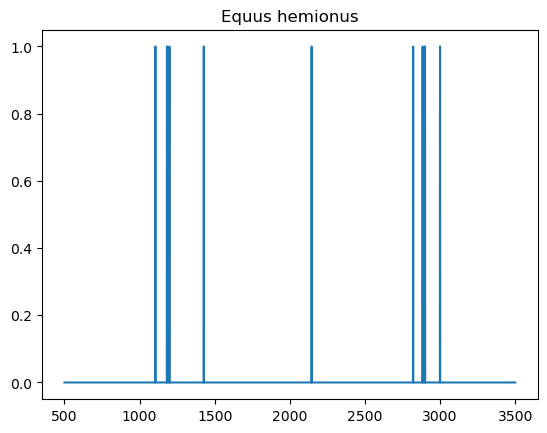

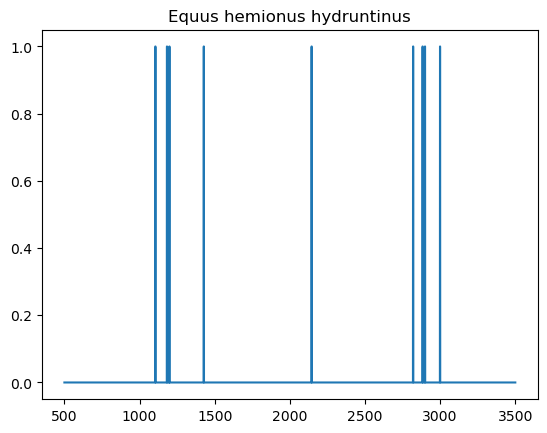

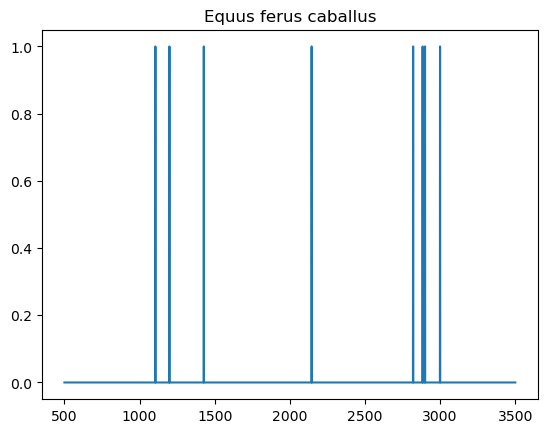

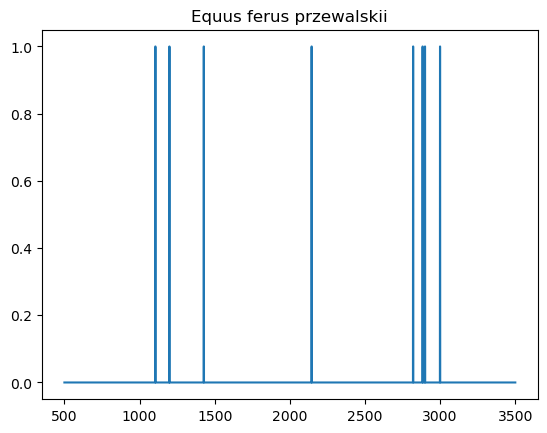

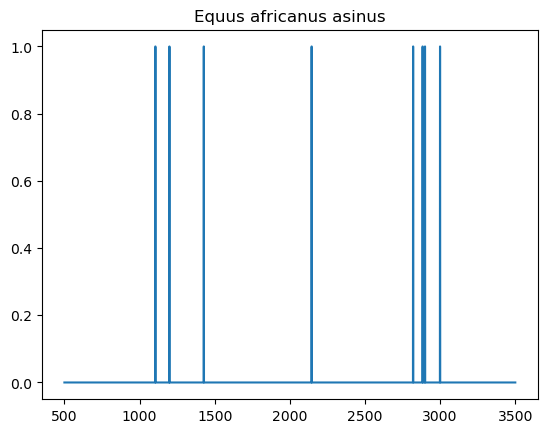

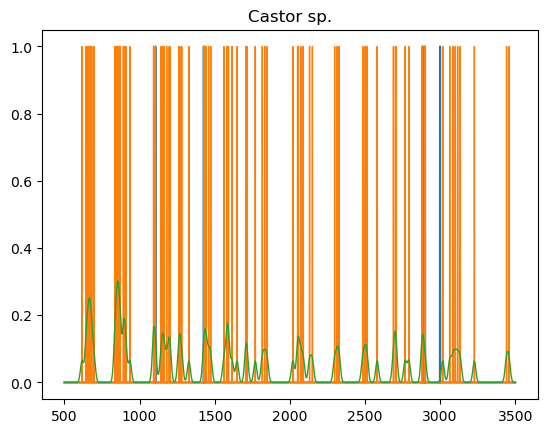

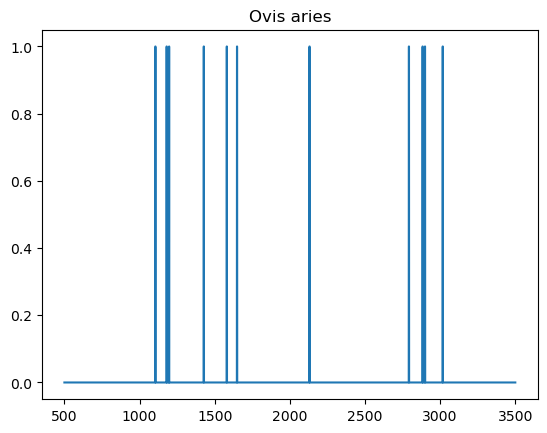

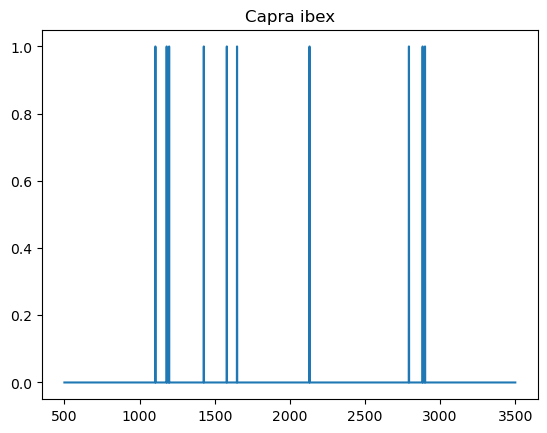

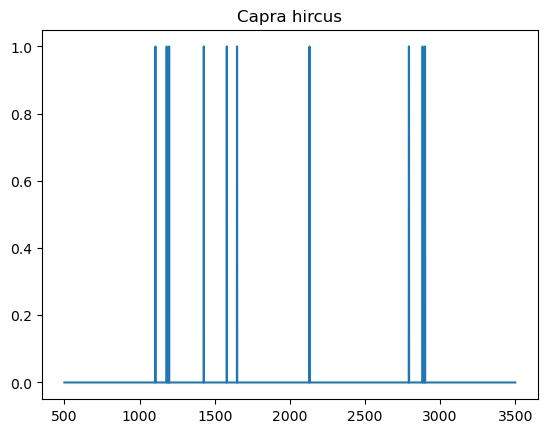

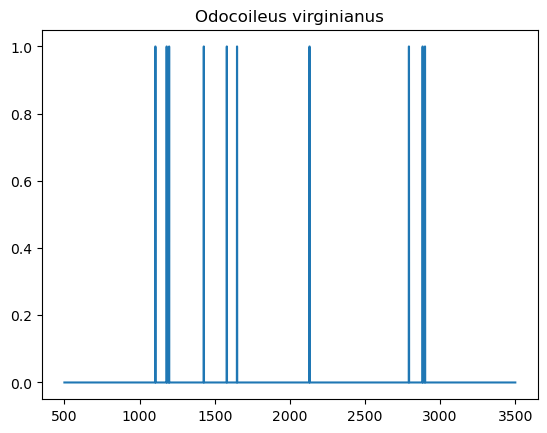

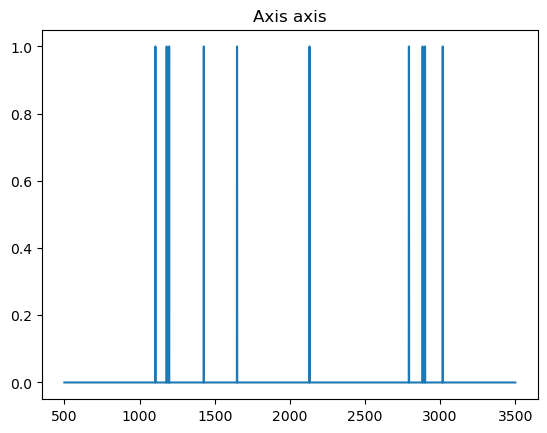

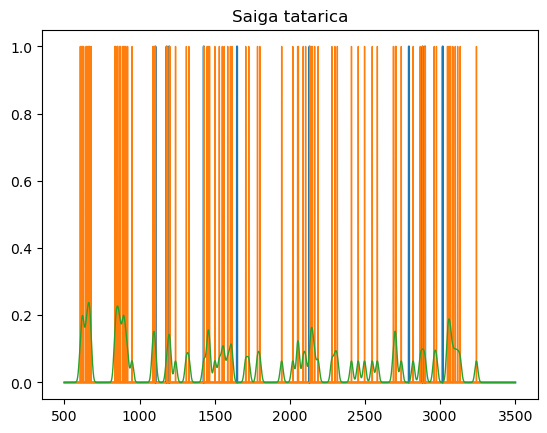

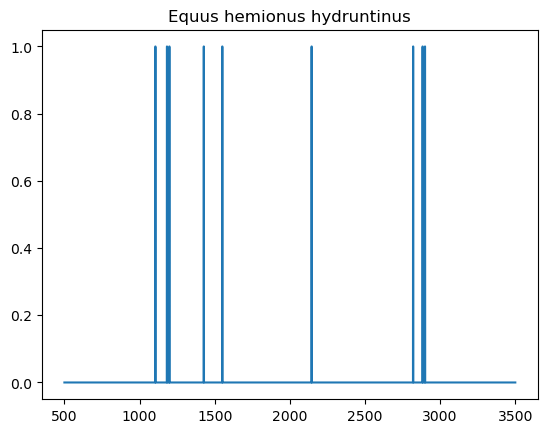

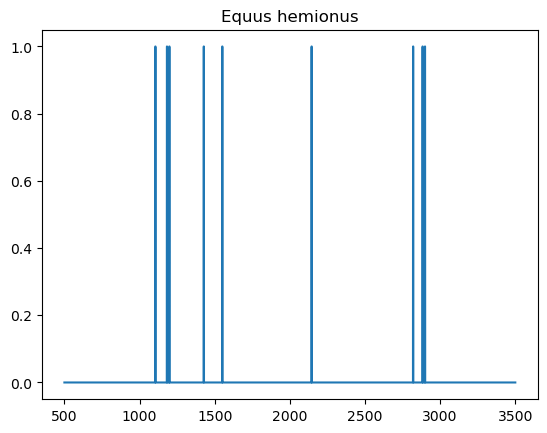

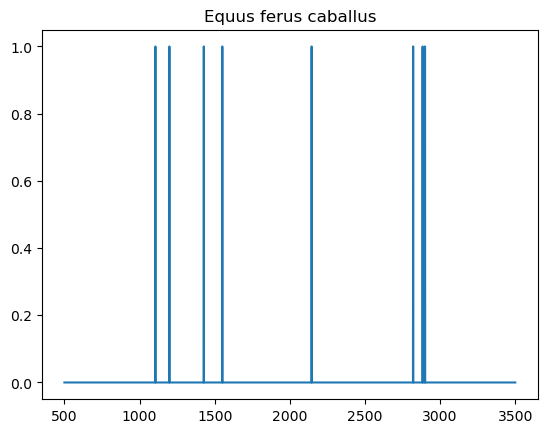

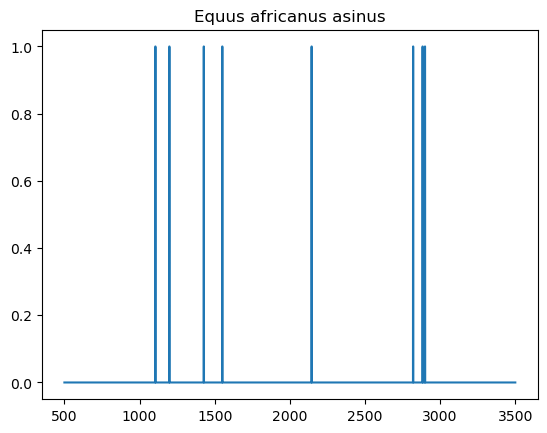

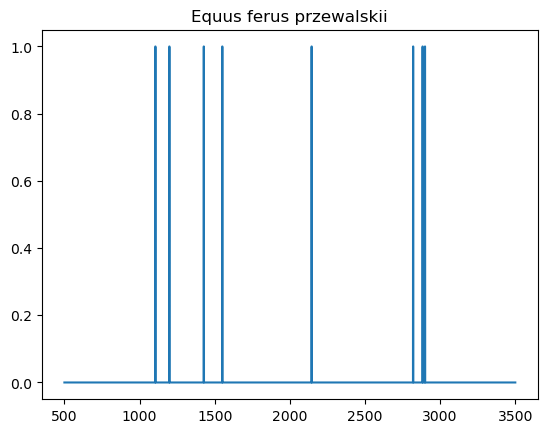

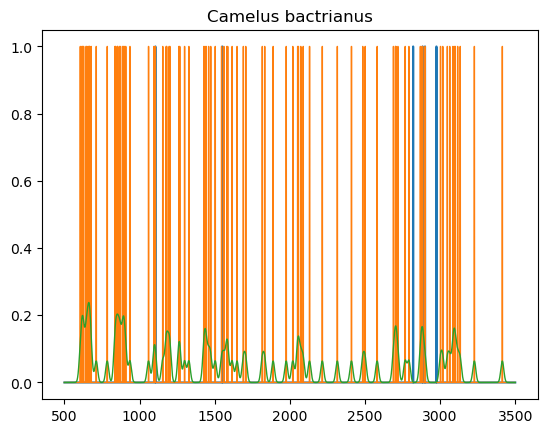

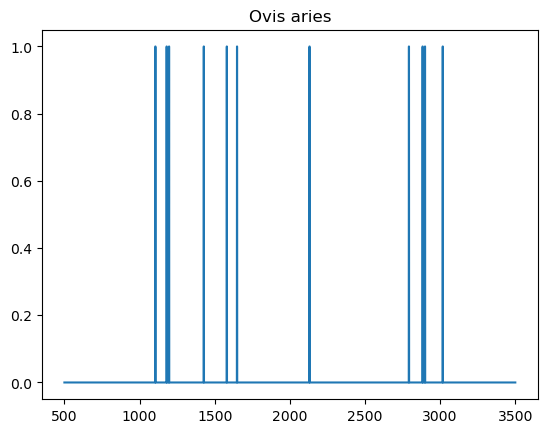

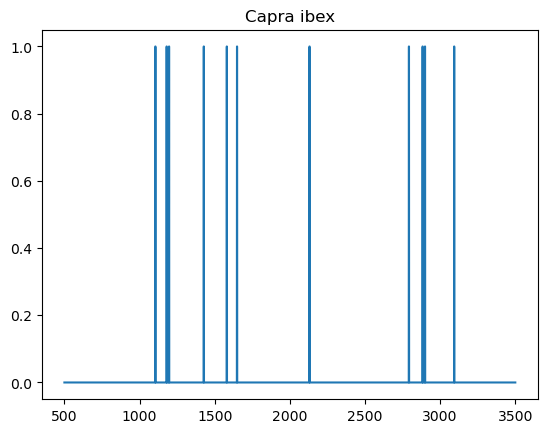

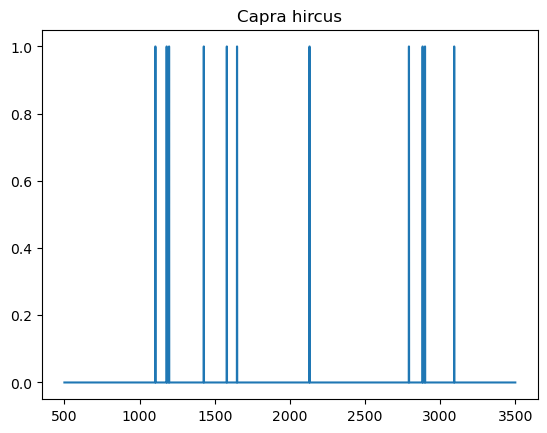

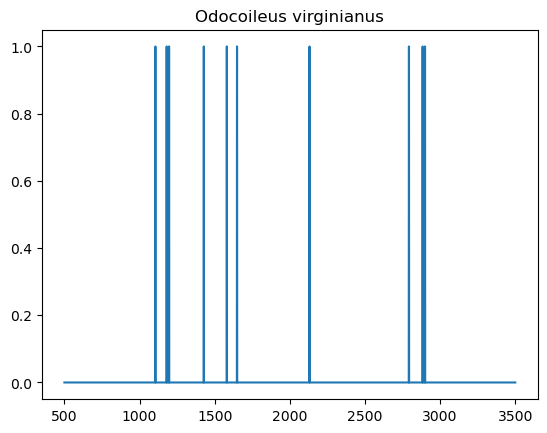

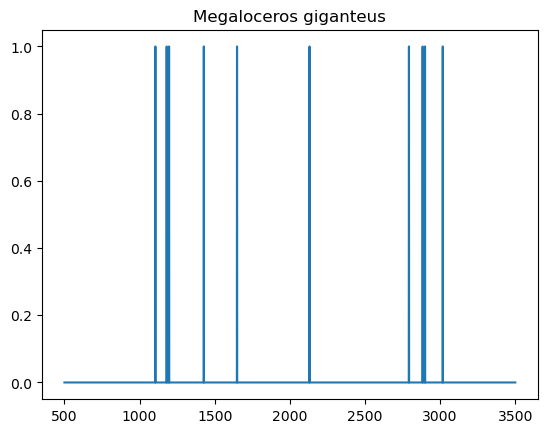

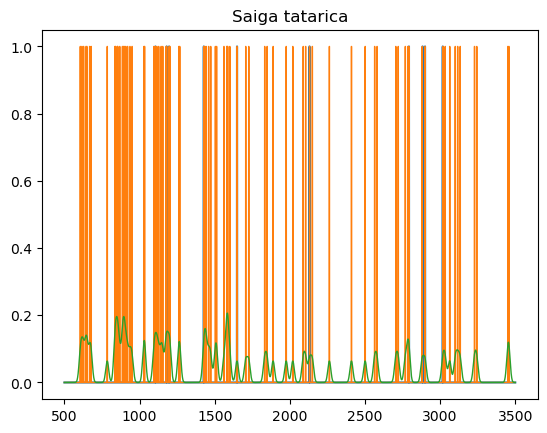

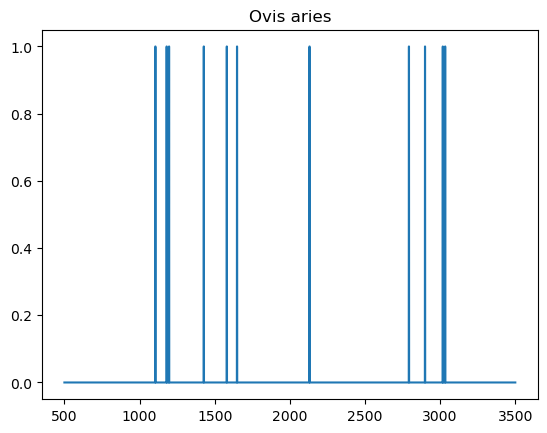

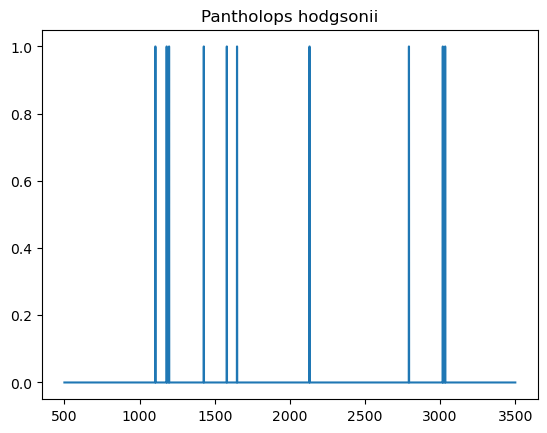

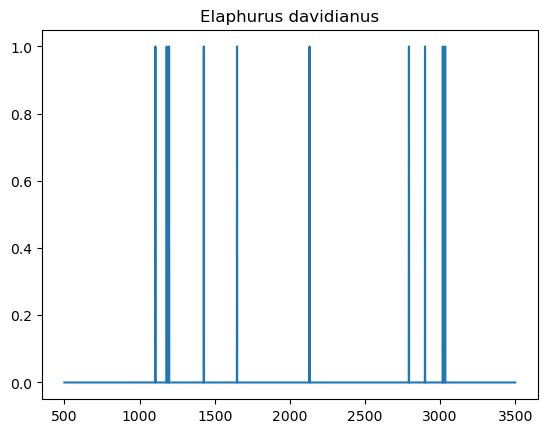

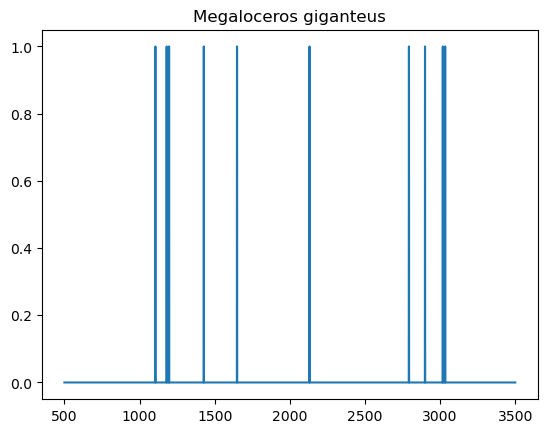

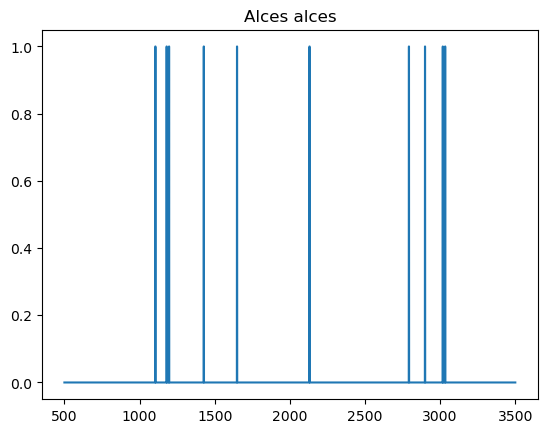

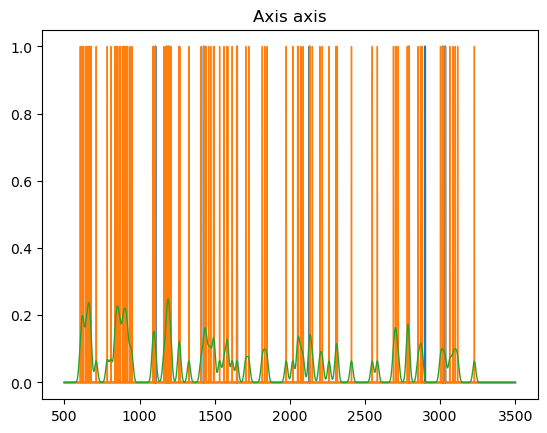

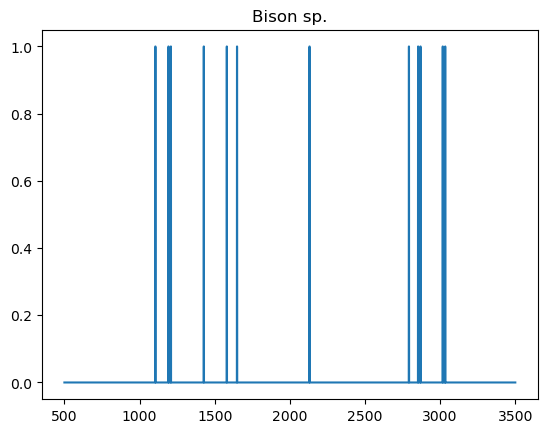

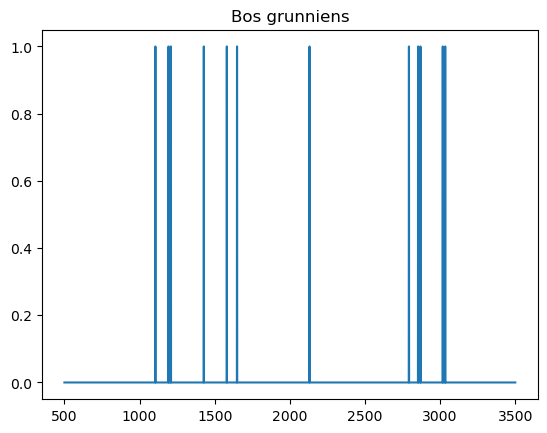

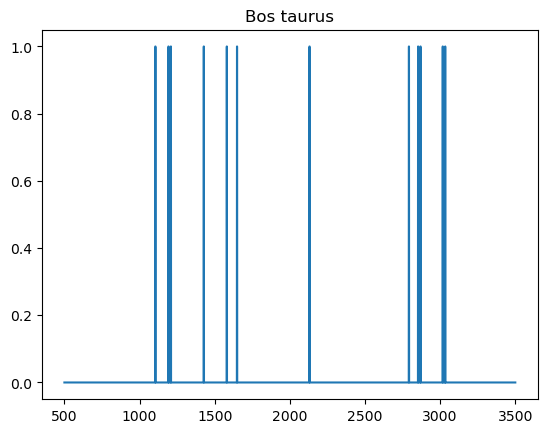

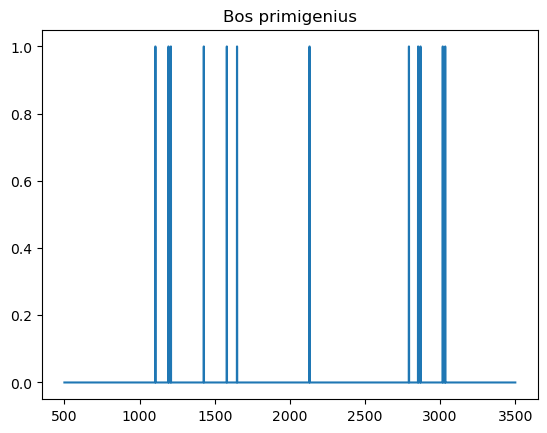

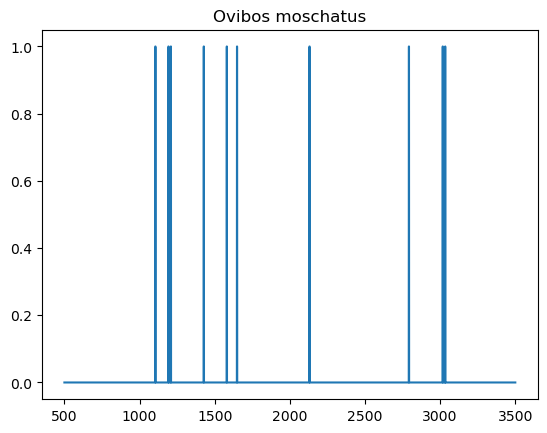

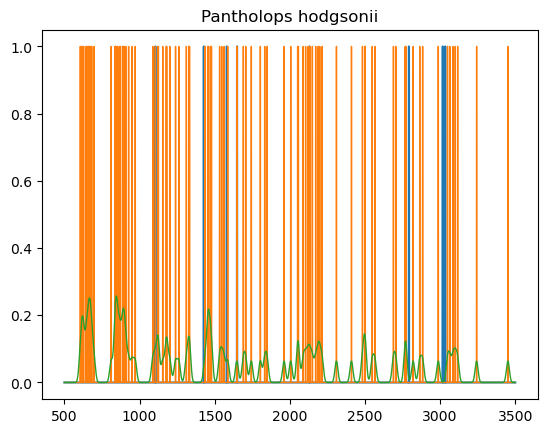

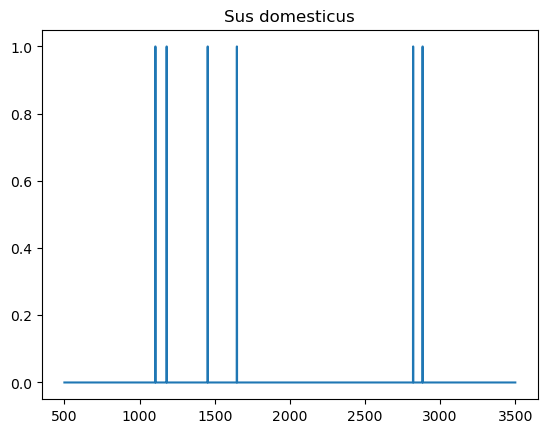

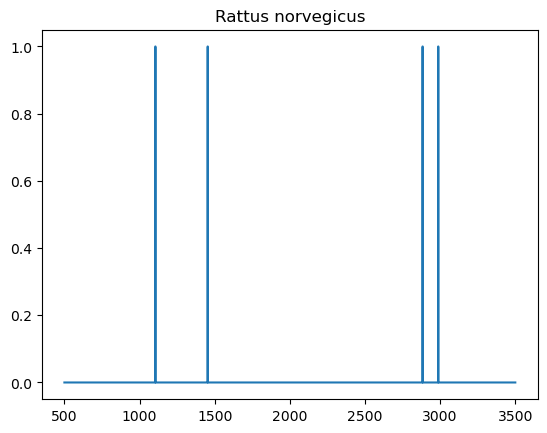

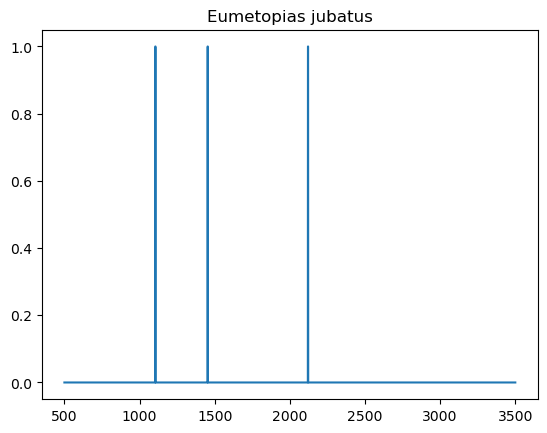

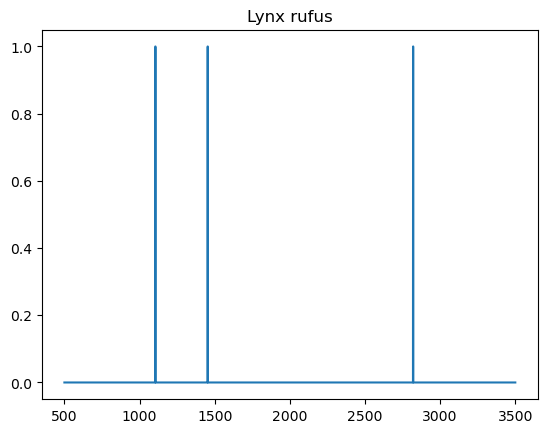

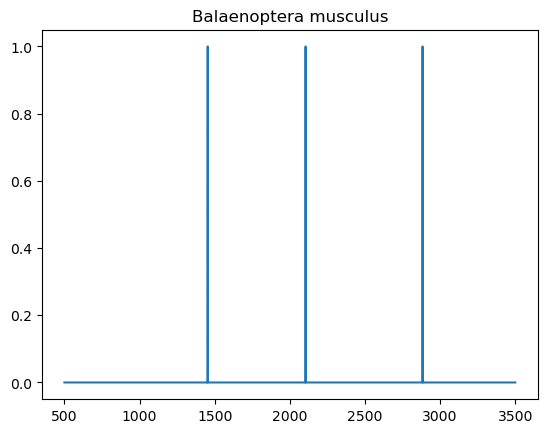

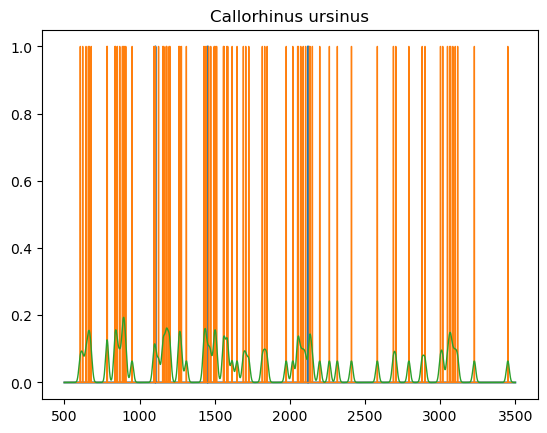

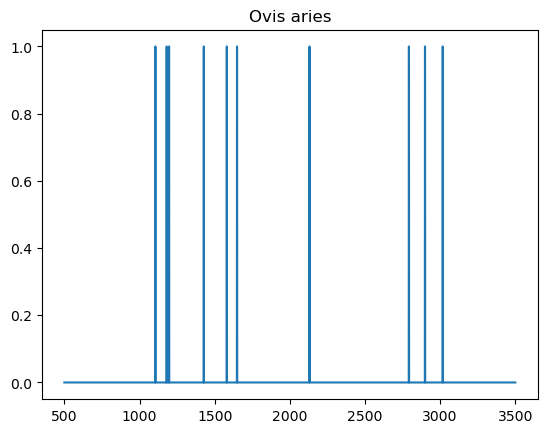

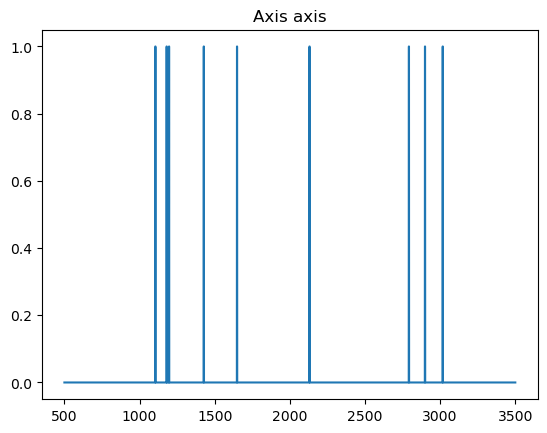

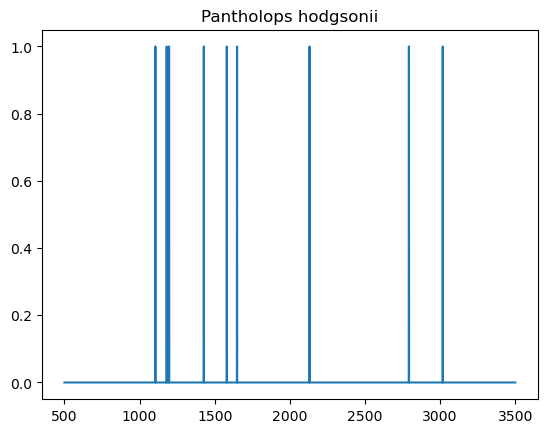

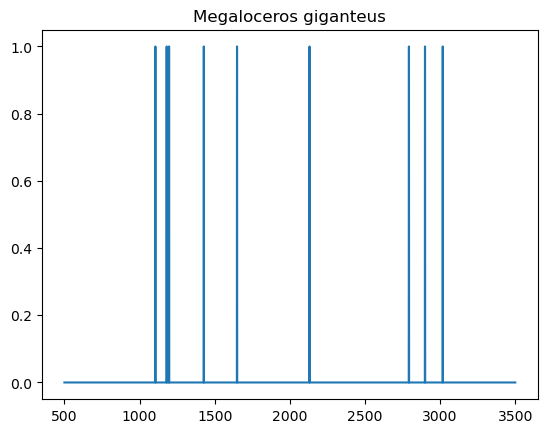

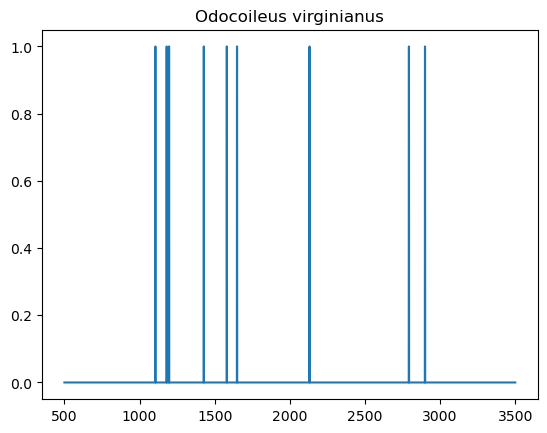

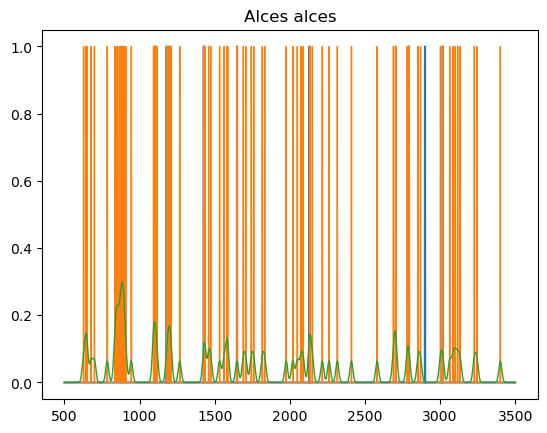

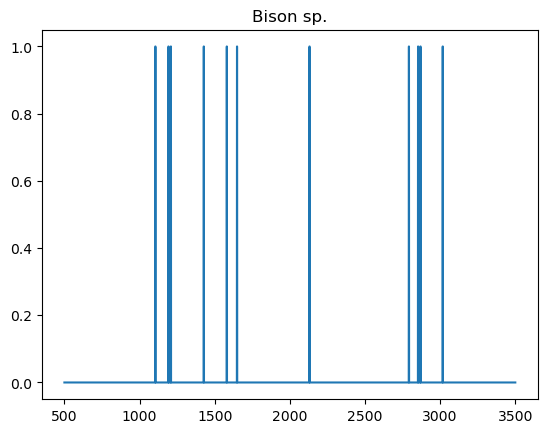

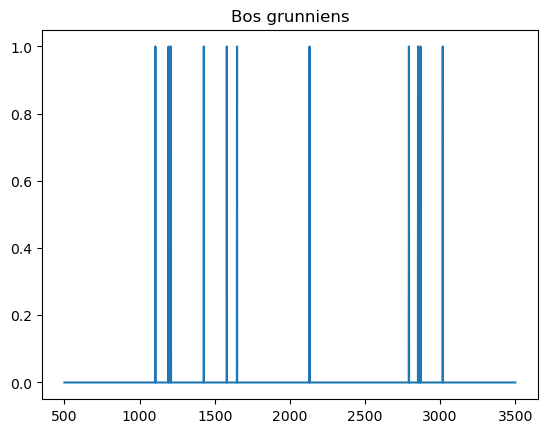

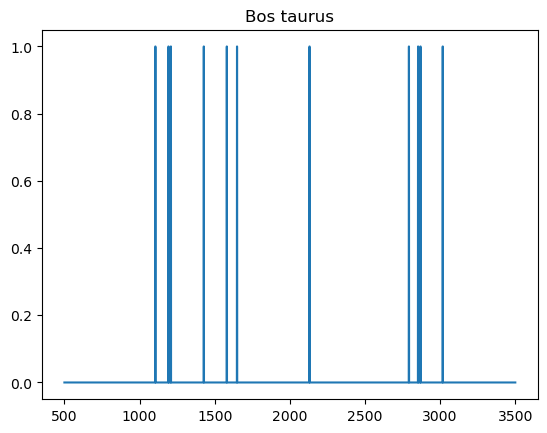

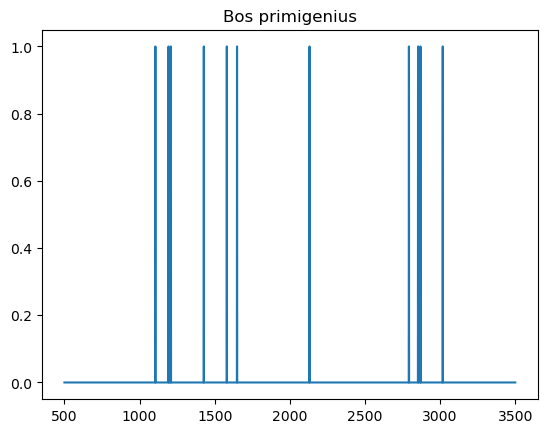

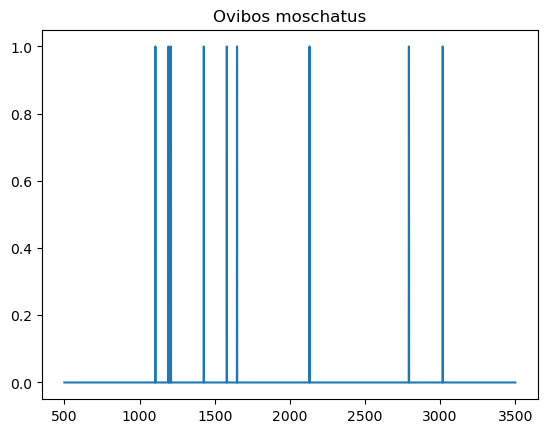

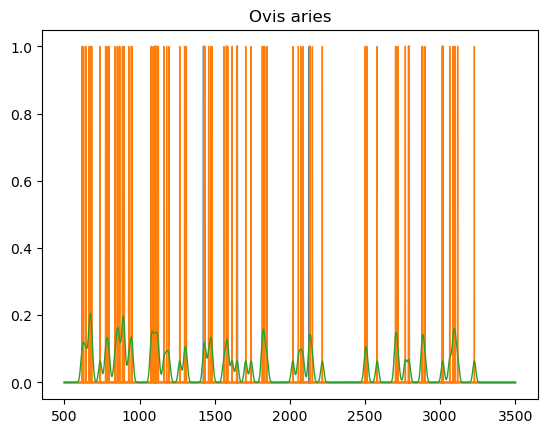

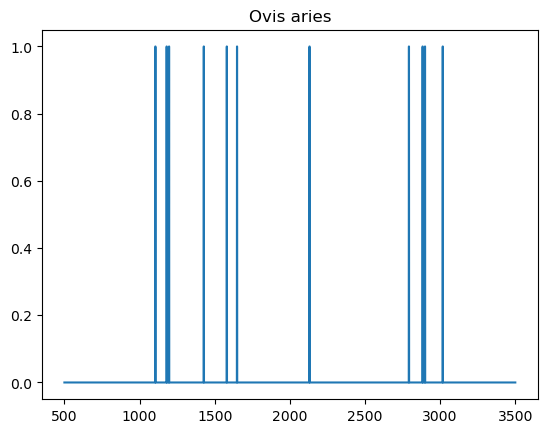

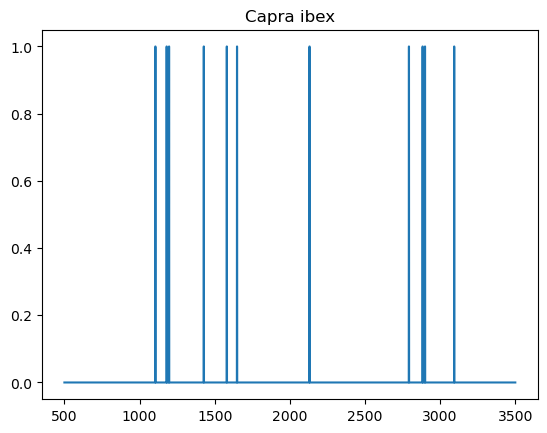

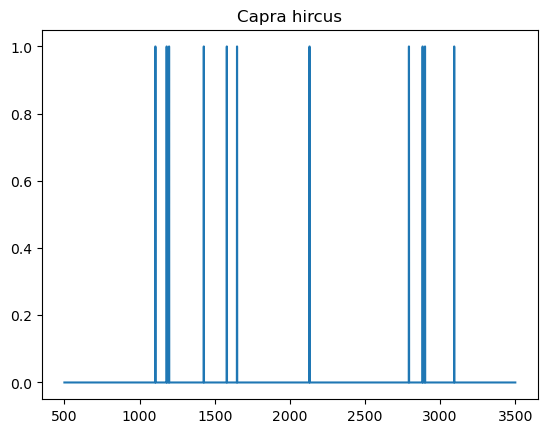

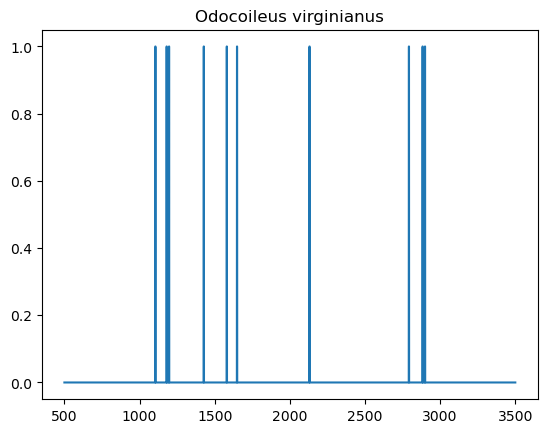

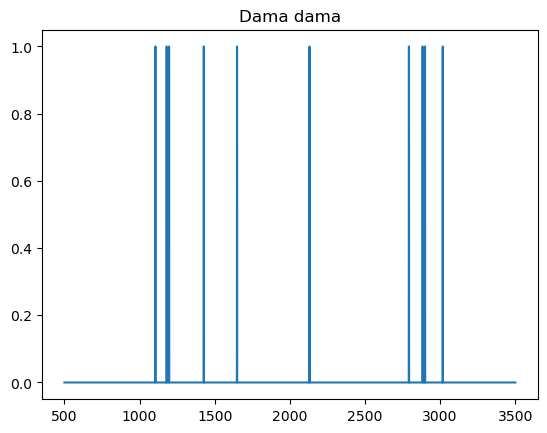

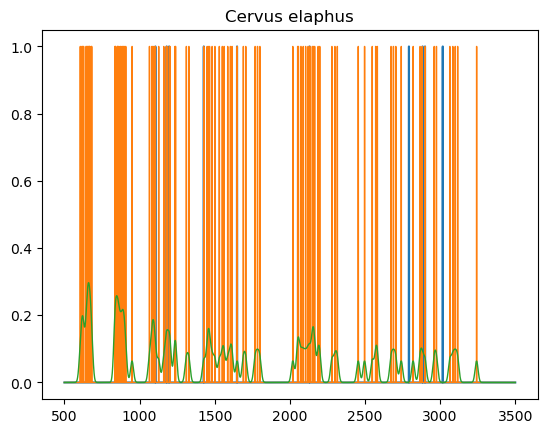

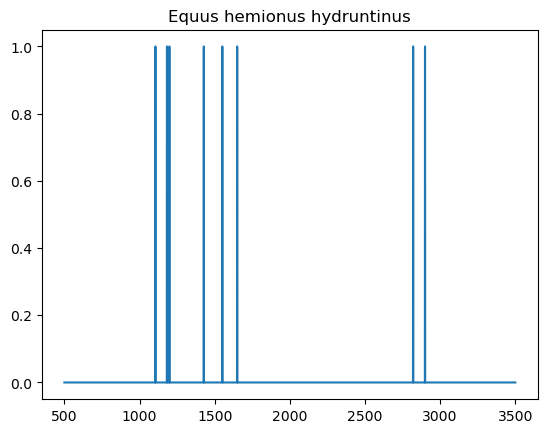

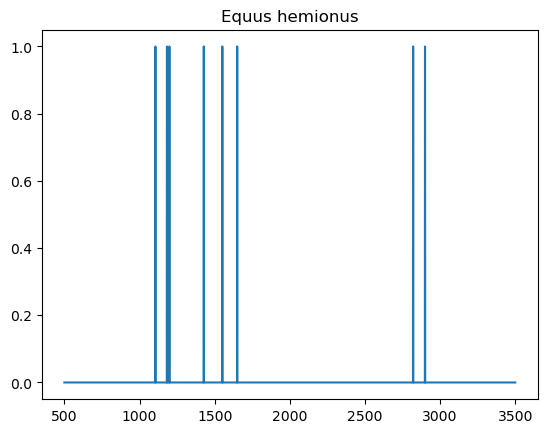

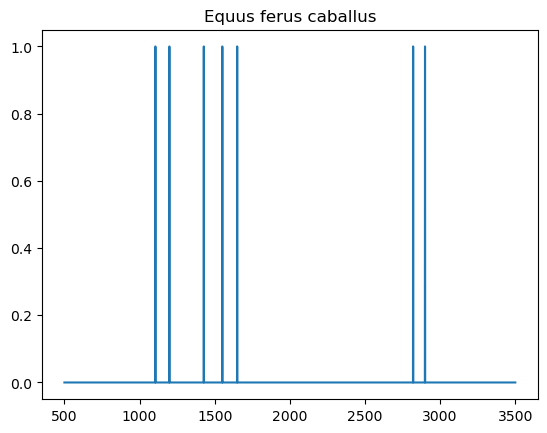

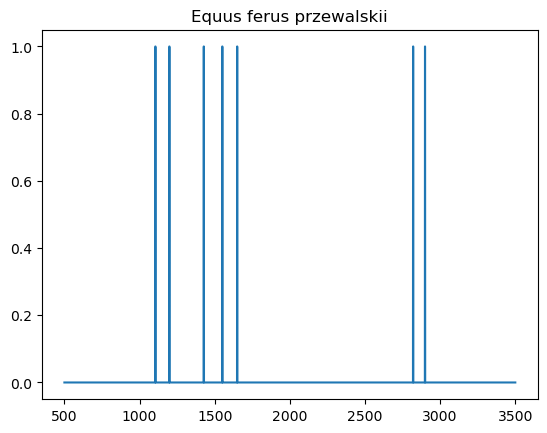

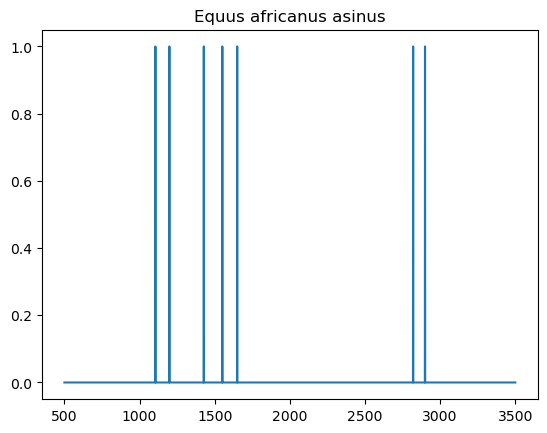

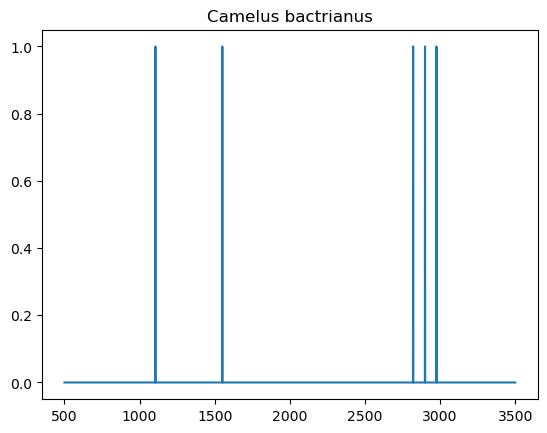

In [24]:
# Make a new folder with original preprocessed peaks to transform the files in a batch to similarity scores
path = "/path_to_new_folder/Batch_similarity"
all_files = glob.glob(path + "/*.csv")

for path in all_files: #no need for the number
    print(f"Processing: {path}") # this will help debugging
    df = pd.read_csv(path)
    df_transformed = transform(df)

    path_no_csv = path.replace(".csv", "") #removes .csv at the end of path
    save_path = path_no_csv + "_similarity.csv" #adds the suffix you want
    df_transformed.to_csv(save_path)

In [25]:
# Delete all csv-s in folder that does not contain 'similarity' in the file name (this will be useful for concatenating)

folder_path = "/path/to/folder"  # Replace with actual path to folder


for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "_similarity" not in filename:
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print("Failed to delete file:", e)

## End of code

## Individual Samples to make changes to the code
If you want to make changes to the code and play around with values, use the following code. This will not batch process files

In [ ]:
x = np.arange(500, 3500, 0.1)
y = np.zeros_like(x)
pi = np.array(ref_peaks.iloc[0].to_numpy())
for p in pi:
    y[np.logical_and(p-x>0.3,p-x<1.3)] = 1

In [ ]:
x = np.arange(500, 3500, 0.1)
y = np.zeros_like(x)
pi = np.array(ref_peaks.iloc[0].to_numpy())
for p in pi:
    y[np.logical_and(p-x>0.3,p-x<1.3)] = 1
    

In [ ]:
x = np.arange(500, 3500, 0.1)
#resampled = reconstructed sample's spectra
resampled = np.zeros_like(x)
for p in df_f9['mass']:
    resampled[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
resampled_smooth = gaussian_filter1d(resampled, 100)
plt.plot(x, resampled, label='sample', linewidth=1)
plt.plot(x, resampled_smooth, label='sample', linewidth=1)

In [ ]:
x = np.arange(500, 3500, 0.1)
resampled = np.zeros_like(x)
for p in df_f9['mass']:
    resampled[np.logical_and(p-x>-0.3,p-x<1.3)] = 1

plt.plot(x, resampled, label='sample', linewidth=1)
corrs = np.zeros(3)

for i in range(3):
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    print(pi)
    for p in pi:
        y[np.logical_and(p-x>0.3,p-x<1.3)] = 1
    plt.plot(x, y, label=reference['Species'][i+1])
    corrs[i] = np.corrcoef(y, resampled)[0,1]
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3);

In [ ]:
n_spec = ref_peaks.shape[0]
corrs = np.zeros(n_spec)
for i in range(n_spec):
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    for p in pi:
        y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
    corrs[i] = np.corrcoef(y, resampled)[0,1]
ranks = pandas.DataFrame({'common':reference['Common_name'][1:],'names':reference['Species'][1:], 'similarity':corrs})

ranks.sort_values(by='similarity', ascending=False).style

In [ ]:
np.round(pi, decimals=2)

In [ ]:
idx = ranks.sort_values(by='similarity', ascending=False).index[:10]
# index [10] because the first 10 matches I want to look at

for i in idx:
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    print(pi)
    for p in pi:
        y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
    plt.figure()
    plt.plot(x, y * resampled)
    print(reference['Species'][i+1])
    v, ix, iy = np.intersect1d((np.round(pi, decimals=1)*10).astype(int), (x[y*resampled==1]*10).astype(int), return_indices=True)
    print(v/10)
    print(ref_peaks.columns[ix])
    plt.title(reference['Species'][i+1]);


In [ ]:
#For debugging: here I tried printing just pi to see what is out of bounds
for i in idx:
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    print(pi)

In [ ]:
idx = ranks.sort_values(by='similarity', ascending=False).index[:6]
all_d = pandas.DataFrame(columns=ref_peaks.columns)
for i in idx:
    y = np.zeros_like(x)
    pi = np.array(ref_peaks.iloc[i].to_numpy())
    for p in pi:
        y[np.logical_and(p-x>-0.3,p-x<1.3)] = 1
    print(reference['Species'][i+1])
    v, ix, iy = np.intersect1d((np.round(pi, decimals=1)*10).astype(int), (x[y*resampled==1]*10).astype(int), return_indices=True)
    d = pandas.DataFrame({k:p for k, p in zip(ref_peaks.columns[ix],v/10)}, index=[reference['Species'][i+1]])
    #print(d.transpose(), '\n')
    all_d = all_d.append(d)
all_d.style

